# Coursework / Arthur Galeev

In [ ]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as T
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.cluster import KMeans
import torchvision

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from munkres import Munkres
from sklearn import metrics

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
np.set_printoptions(precision=3, suppress=True)
torch.set_printoptions(precision=3, sci_mode=False)

## Metrics

In [4]:
class BCubed:
    def __init__(self, gold_standard):
        self.gold_standard = gold_standard

    def correctness(self, label, index, labels, same_cluster_indexes):
        same_predictions = labels[same_cluster_indexes] == label
        same_real = self.gold_standard[same_cluster_indexes] == self.gold_standard[index]
        return (same_predictions * same_real).sum()

    def precition_bcubed(self, labels):
        precition_bcubed = 0
        for index, label in enumerate(labels):
            same_cluster_indexes = np.where(self.gold_standard == self.gold_standard[index])[0]
            precition_bcubed += self.correctness(label, index, labels, same_cluster_indexes) / len(same_cluster_indexes)
        return precition_bcubed / len(labels)


    def recall_bcubed(self, labels):
        recall_bcubed = 0
        for index, label in enumerate(labels):
            same_cluster_indexes = np.where(labels == label)[0]
            recall_bcubed += self.correctness(label, index, labels, same_cluster_indexes) / len(same_cluster_indexes)
        return recall_bcubed / len(labels)

    def __call__(self, labels):
        precision = self.precition_bcubed(labels)
        recall = self.recall_bcubed(labels)
        return 2 * precision * recall / (precision + recall)

In [5]:
def get_preds_labels(y_true, y_preds, num_clusters):
    conf_matrix = confusion_matrix(y_true, y_preds, labels=None)
    cost_matrix = np.zeros((num_clusters, num_clusters))
    for i in range(num_clusters):
        n_cur_instances = cost_matrix[:, i].sum()
        cost_matrix[:, i] = n_cur_instances - conf_matrix[:, i]

    cost_matrix = cost_matrix.T
    munkres_indicies = Munkres().compute(cost_matrix)
    y_preds_munkres = np.zeros_like(y_preds)
    permutated_clusters = np.zeros(num_clusters)
    for i in range(num_clusters):
        permutated_clusters[i] = int(munkres_indicies[i][1])

    return permutated_clusters[y_preds]

def calc_accuracy(y_true, y_preds, num_clusters):
    reordered_preds = get_preds_labels(y_true, y_preds, num_clusters)
    return accuracy_score(y_true, reordered_preds)

In [6]:
def evaluate(y_true, preds, num_clusters):
    acc = calc_accuracy(y_true, preds, num_clusters)
    nmi = metrics.normalized_mutual_info_score(y_true, preds)
    ari = metrics.adjusted_rand_score(y_true, preds)
    fmi = metrics.fowlkes_mallows_score(y_true, preds)
    bcubed = BCubed(y_true)
    bc = bcubed(preds)
    return acc, nmi, ari, fmi, bc

## Datasets

### MNIST

In [7]:
from torchvision.datasets import MNIST


mnist_train = MNIST(
    "../datasets/mnist",
    train=True,
    download=True,
    transform=T.Compose([
        T.ToImage(), 
        T.ToDtype(torch.float32, scale=True),
        nn.Flatten()
    ])
)

mnist_test = MNIST(
    "../datasets/mnist",
    train=False,
    download=True,
    transform=T.Compose([
        T.ToImage(), 
        T.ToDtype(torch.float32, scale=True),
        nn.Flatten()
    ])
)

mnist_train_set, mnist_valid_set = torch.utils.data.random_split(mnist_train, [55000, 5000])

mnist_train_loader = DataLoader(mnist_train_set, batch_size=64)
mnist_valid_loader = DataLoader(mnist_valid_set, batch_size=64)
mnist_test_loader = DataLoader(mnist_test, batch_size=64)

### CIFAR10

In [8]:
from torchvision.datasets import CIFAR10


cifar_train = CIFAR10(
    "../datasets/mnist",
    train=True,
    download=True,
    transform=T.Compose([
        T.ToImage(), 
        T.ToDtype(torch.float32, scale=True),
        nn.Flatten()
    ])
)
cifar_test = CIFAR10(
    "../datasets/mnist",
    train=False,
    download=True,
    transform=T.Compose([
        T.ToImage(), 
        T.ToDtype(torch.float32, scale=True),
        nn.Flatten()
    ])
)

cifar_train_set, cifar_valid_set = torch.utils.data.random_split(cifar_train, [45000, 5000])

cifar_train_loader = DataLoader(cifar_train_set, batch_size=64)
cifar_valid_loader = DataLoader(cifar_valid_set, batch_size=64)
cifar_test_loader = DataLoader(cifar_test, batch_size=64)

### MNIST for CC

In [9]:
class CCTransforms:
    def __init__(self, size, mean=None, std=None):
        self.transforms = torchvision.transforms.Compose(
            [
                torchvision.transforms.RandomResizedCrop(size=size),
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.RandomApply([torchvision.transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)],
                                                  p=0.8),
                torchvision.transforms.RandomGrayscale(p=0.2),
                torchvision.transforms.v2.GaussianBlur(kernel_size=23),
                torchvision.transforms.ToTensor(),
                # torchvision.transforms.Normalize(mean=mean, std=std)
            ]
        )

    def __call__(self, x):
        return self.transforms(x), self.transforms(x)

In [10]:
mnist_cc_train = MNIST(
    "../datasets/mnist",
    train=True,
    download=True,
    transform=CCTransforms(size=28)
)

mnist_cc_valid = MNIST(
    "../datasets/mnist",
    train=False,
    download=True,
    transform=CCTransforms(size=28)
)

mnist_cc_train_loader = DataLoader(mnist_cc_train, batch_size=256, drop_last=True)
mnist_cc_valid_loader = DataLoader(mnist_cc_valid, batch_size=256, drop_last=True)

### CIFAR10 for CC

In [11]:
class CCTransforms:
    def __init__(self, size, mean=None, std=None):
        self.transforms = torchvision.transforms.Compose(
            [
                torchvision.transforms.RandomResizedCrop(size=size),
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.RandomApply([torchvision.transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)],
                                                  p=0.8),
                torchvision.transforms.RandomGrayscale(p=0.2),
                torchvision.transforms.v2.GaussianBlur(kernel_size=23),
                torchvision.transforms.ToTensor(),
                # torchvision.transforms.Normalize(mean=mean, std=std)
            ]
        )

    def __call__(self, x):
        return self.transforms(x), self.transforms(x)

In [12]:
cifar_cc_train = CIFAR10(
    "../datasets/mnist",
    train=True,
    download=True,
    transform=CCTransforms(size=32)
)

cifar_cc_valid = CIFAR10(
    "../datasets/mnist",
    train=False,
    download=True,
    transform=CCTransforms(size=32)
)

cifar_cc_train_loader = DataLoader(cifar_cc_train, batch_size=256, drop_last=True)
cifar_cc_valid_loader = DataLoader(cifar_cc_valid, batch_size=256, drop_last=True)

## Topological Features

Имплементация взята [отсюда](https://github.com/vincent-grande/topf).

In [13]:
import ast
import os
import sys
from importlib import resources
import csv
import subprocess
import warnings
from io import StringIO
import numpy as np
import gudhi as gd
import matplotlib.cm
import matplotlib.colors
import scipy.sparse
import scipy.spatial
import scipy.linalg
from scipy.optimize import LinearConstraint, milp
from sklearn.neighbors import KNeighborsRegressor
import sklearn.cluster
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

In [14]:
def topf(
    base_points,
    complex_type="auto",
    thresh_distance=0,
    max_hom_dim=1.0,
    max_rel_quot=0.1,
    interpolation_coefficient=0.3,
    weight_exponent=-1,
    simplex_threshs=(0.1, 0.1),
    max_num_simplices_drawn=750,
    n_clusters="auto",
    draw_reps=False,
    draw_scaled_vecs=False,
    draw_final_clustering=False,
    draw_signatures=False,
    rep_chance=1,
    damping=0,
    eigenvector_tresholding=True,
    eigenvector_threshold=0.07,
    clustering_method="spectral",
    exponential_interpolation=True,
    max_total_quot=0.1,
    quotient_life_times=False,
    use_eff_resistance=False,
    draw_signature_heatmaps="Off",
    aggregation_mode="mean",
    eff_resistance_exponent=2,
    verbose=False,
    max_reps=100,
    dim0min_pers_ratio=5,
    thresholding_type="linear",
    add_convex_hull=False,
    only_dims=[0, 1, 2, 3],
    permit_inf_homology_classes=True,
    sparsify_input="auto",
    num_sparse_points=1000,
    fixed_num_features="Off",
    return_dict=False,
):

    """
        Returns Topological point features of a point cloud.

        Parameters 
        ----------
        base_points : np.array
            The points to be analyzed.
        complex_type : str, optional
            The type of the complex to be used. Can be 'alpha' or 'rips'. If 'auto', the complex is chosen automatically. The default is 'auto'.
        thresh_distance : float, optional
            The distance threshold for the complex. The default is 0 which disables the threshold.
        max_hom_dim : int, optional
            The maximum homological dimension to be computed. The default is 1.
        max_rel_quot : float, optional
            The maximum relative quotient of the life times of the homology classes to be picked. The default is 0.1.
        interpolation_coefficient : float, optional
            The interpolation coefficient which determines the simplicial complex for the harmonic projection. The default is 0.3.
        simplex_threshs : tuple, optional
            The threshold for the associated values of the simplices in dimension 1 & 2 to be drawn when draw_scaled_vecs = True. The default is (0.1, 0.1).
        n_clusters : int, optional
            The number of clusters to be computed. If 'auto', the number of clusters is chosen automatically. The default is 'auto'.
        draw_reps : bool, optional
            Whether to draw the representatives. The default is False.
        draw_scaled_vecs : bool, optional
            Whether to draw the postprocessed harmonic representatives. The default is False.
        draw_final_clustering : bool, optional
            Whether to draw the final clustering. The default is False.
        draw_signatures : bool, optional
            Whether to plot the topopological feature vectors in 3d feature space. The default is False.
        rep_chance : float, optional
            The chance of drawing a representative. The default is 1.
        damping : float, optional
            Factor that influences feature selection. Increasing the damping coefficient will introduce a bias towards selecting more features. The default is 0.
        eigenvector_tresholding : bool, optional
            Whether to threshold the eigenvector components. The default is True.
        eigenvector_threshold : float, optional
            The threshold for the eigenvector components. The default is 0.07.
        clustering_method : str, optional
            The clustering method to be used. Can be 'kmeans', 'spectral' or 'agglomerative'. The default is 'auto'.
        exponential_interpolation : bool, optional
            Whether to use exponential interpolation opposed to linear interpolation for computing the simplicial complexes. The default is True.
        max_total_quot : float, optional
            The maximum total quotient of the life times of the homology classes to be picked. The default is 0.1.
        quotient_life_times : bool, optional
            Whether to use the quotient of the death and birth times of the homology classes as their relevance score opposed to the difference. The default is False.
        use_eff_resistance : bool, optional
            Whether to use effective resistance for the harmonic projection. The default is False. Computation intensive.
        draw_signature_heatmaps : str, optional
            Whether to draw the heatmaps of the signatures. Can be 'Off', 'One plot' to combine them in one plot only showing the most significant features, 'Separate plots' to draw a heatmap for each of the features individually. The default is 'Off'.
        aggregation_mode : str, optional
            The aggregation mode for the short signatures. Can be 'mean', 'max', 'min', 'sum'. The default is 'mean'.
        eff_resistance_exponent : int, optional
            The exponent for the weight computation. The default is 2.
        verbose : bool, optional
            Whether to print the progress. The default is False. Very verbose.
        max_reps : int, optional
            The maximum number of representatives to be picked. The default is 100.
        dim0min_pers_ratio : int, optional
            The ratio of the minimum persistence of dimension 0 homology classes to be picked. The default is 5.
        thresholding_type : str, optional
            The type of thresholding to be used for the eigenvector components. Can be 'linear', 'hard'. The default is 'linear'.
        add_convex_hull : bool, optional
            Whether to add the convex hull of the points to the points. The default is False.
        only_dims : list, optional
            The dimensions to be considered. The default is [0, 1, 2, 3].
        permit_inf_homology_classes : bool, optional
            Whether to consider homology classes without a death time (due to thresholding). The default is True and their death time is set to the picked threshold.
        sparsify_input : str, optional
            The sparsification method to be used. Can be 'landmark', 'random', 'mixed', 'off', 'auto'. The default is 'auto'.
        num_sparse_points : int, optional
            The number of points to be picked after sparsification. The default is 1000. Gets overwritten by sparsify_input = 'auto'.
        fixed_num_features : list/str, optional
            The number of features to be picked for each dimension in the form of a list. The default is 'Off'.
        return_dict : bool, optional
            Whether to return the dictionary with labels and additional information. The default is False.

        Returns
        -------
        topological features : np.array
            The topological features.
        (Optional if return_dict = True) output_dict: dict
    """
    if not isinstance(interpolation_coefficient, float):
        raise ValueError("interpolation_coefficient must be a float.")
    if interpolation_coefficient <= 0 or interpolation_coefficient >= 1:
        raise ValueError("interpolation_coefficient must be in (0,1).")
    if not isinstance(n_clusters, int) and n_clusters != "auto":
        raise ValueError("n_clusters must be an integer or 'auto'.")
    if clustering_method not in ["kmeans", "spectral", "agglomerative"]:
        raise ValueError(
            "clustering_method must be 'kmeans', 'spectral', or 'agglomerative'."
        )
    if draw_signature_heatmaps not in ["Off", "One plot", "Separate plots"]:
        raise ValueError(
            "draw_signature_heatmaps must be 'Off', 'One plot', or 'Separate plots'."
        )
    if not isinstance(draw_reps, bool):
        raise ValueError("draw_reps must be a boolean.")
    if not isinstance(draw_scaled_vecs, bool):
        raise ValueError("draw_scaled_vecs must be a boolean.")
    if not isinstance(draw_final_clustering, bool):
        raise ValueError("draw_final_clustering must be a boolean.")
    if not isinstance(draw_signatures, bool):
        raise ValueError("draw_signatures must be a boolean.")
    if not isinstance(eigenvector_tresholding, bool):
        raise ValueError("eigenvector_tresholding must be a boolean.")
    if not isinstance(quotient_life_times, bool):
        raise ValueError("quotient_life_times must be a boolean.")
    if sparsify_input not in ["landmark", "random", "mixed", "off", "auto"]:
        raise ValueError(
            "sparsify_input must be 'landmark', 'random', 'mixed', 'off', or 'auto'."
        )
    if not isinstance(return_dict, bool):
        raise ValueError("return_dict must be a boolean.")
    if not isinstance(verbose, bool):
        raise ValueError("verbose must be a boolean.")
    if not isinstance(fixed_num_features, list) and fixed_num_features != "Off":
        raise ValueError("fixed_num_features must be a list or 'Off'.")
    if complex_type not in ["alpha", "rips", "auto"]:
        raise ValueError("complex_type must be 'alpha', 'rips', or 'auto.")
    base_points = noisify_input_points(np.array(base_points))
    ambient_dim = base_points.shape[1]
    if max_hom_dim >= ambient_dim:
        warnings.warn(
            "max_hom_dim is larger than the ambient dimension. There are no n-dimensional topological features in an n-dimensional space. Setting max_hom_dim to ambient_dim-1.",
            category=RuntimeWarning,
        )
        max_hom_dim = ambient_dim - 1
    num_input_points = base_points.shape[0]
    first_stage_sparsifier = num_input_points
    original_points = np.copy(base_points)
    if complex_type == "auto":
        if ambient_dim < 4:
            complex_type = "alpha"
            if verbose:
                print("Alpha complex chosen.")
        else:
            complex_type = "rips"
            if verbose:
                print("Rips complex chosen.")
    if sparsify_input == "auto":
        if verbose:
            print("Sparsification heuristic chosen.")
        (
            sparsify_input,
            num_sparse_points,
            first_stage_sparsifier,
        ) = decide_sparseness_parameters(
            complex_type=complex_type,
            max_hom_dim=max_hom_dim,
            ambient_dim=ambient_dim,
            num_input_points=num_input_points,
            verbose=verbose,
        )
    if sparsify_input == "landmark" and num_sparse_points < num_input_points:
        base_points, selected_base_points = minmax_landmark_sampling(
            base_points, num_sparse_points
        )
        if verbose:
            print(
                "Landmark sampling done from "
                + str(num_input_points)
                + " to "
                + str(num_sparse_points)
            )
    elif sparsify_input == "random" and num_sparse_points < num_input_points:
        base_points = random_sampling(base_points, num_sparse_points)
        if verbose:
            print(
                "Random sampling done from "
                + str(num_input_points)
                + " to "
                + str(num_sparse_points)
            )
    elif sparsify_input == "mixed" and num_sparse_points < num_input_points:
        base_points = random_sampling(base_points, first_stage_sparsifier)
        base_points, selected_base_points = minmax_landmark_sampling(
            base_points, num_sparse_points
        )
        if verbose:
            print(
                "Mixed sampling done from "
                + str(num_input_points)
                + " to "
                + str(num_sparse_points)
            )
    num_old_base_points = base_points.shape[0]
    if add_convex_hull:
        base_points = np.concatenate(
            (base_points, construct_convex_hull(base_points)), axis=0
        )
    if verbose:
        print("Points saved. Starting Ripserer...")
    julia_input_string = ""
    for point in tqdm(base_points):
        for coord in point:
            julia_input_string += f"{coord} "
        julia_input_string = julia_input_string[:-1]
        julia_input_string += "\n"
    ripserer_raw_output = subprocess.check_output(
        [
            "julia",
            "--project=.topf/JuliaEnvironment",
            ".topf/HomologyGeneratorsMultiD.jl",
            str(thresh_distance),
            str(max_hom_dim),
            complex_type,
        ],
        input=julia_input_string,
        text=True,
    )
    ripserer_output_csv_files = ripserer_raw_output.split("newfile")
    if verbose:
        print("Ripserer finished. Reading Reps...")
    multi_reps, multi_inds, multi_life_times = extract_reps(
        complex_type,
        max_hom_dim,
        thresh_julia=thresh_distance,
        max_rel_quot=max_rel_quot,
        ripserer_output_csv_files=ripserer_output_csv_files,
        damping=damping,
        max_total_quot=max_total_quot,
        quotient_life_times=quotient_life_times,
        verbose=verbose,
        max_reps=max_reps,
        dim0min_pers_ratio=dim0min_pers_ratio,
        only_dims=only_dims,
        permit_inf_homology_classes=permit_inf_homology_classes,
        fixed_num_features=fixed_num_features,
    )
    if verbose:
        print(multi_inds)
    if n_clusters == "auto":
        n_clusters = np.sum([len(cur_indices) for cur_indices in multi_inds])
    if verbose:
        print("Reading done. Computing Projections...")
    multi_eigen_vecs = [[], [], []]
    multi_scaled_vecs = [[], [], []]
    multi_multi_simplices = [[], [], []]
    multi_multi_points = [[], [], []]
    multi_scaled_vecs_save = []
    multi_all_num_k_simplices_in_p = [[], [], []]
    for cur_d in range(len(multi_inds)):
        if verbose:
            print("Computing Projection for Dimension " + str(cur_d))
        (
            eigen_vecs,
            scaled_vecs,
            all_num_k_simplices_in_p,
            multi_points,
            multi_simplices,
            multi_inds,
        ) = compute_projection_from_reps(
            base_points,
            cur_d,
            multi_inds,
            multi_reps,
            multi_life_times,
            m=interpolation_coefficient,
            weight_exponent=weight_exponent,
            complex_type=complex_type,
            exponential_interpolation=exponential_interpolation,
            use_eff_resistance=use_eff_resistance,
            eff_resistance_exponent=eff_resistance_exponent,
            verbose=verbose,
        )
        multi_eigen_vecs[cur_d] = eigen_vecs
        multi_scaled_vecs_save.append([np.copy(array) for array in scaled_vecs])
        if eigenvector_tresholding:
            for i, vec in enumerate(scaled_vecs):
                scaled_vecs[i] = np.array(
                    [
                        my_threshold(
                            value=v,
                            threshold=eigenvector_threshold,
                            thresholding_type=thresholding_type,
                        )
                        for v in vec
                    ]
                )
        multi_scaled_vecs[cur_d] = [np.copy(array) for array in scaled_vecs]
        multi_all_num_k_simplices_in_p[cur_d] = all_num_k_simplices_in_p
        multi_multi_points[cur_d] = multi_points
        multi_multi_simplices[cur_d] = multi_simplices
    if verbose:
        print("Computation done. Plotting representatives...")
    if draw_reps:
        draw_representatives(
            base_points,
            max_hom_dim,
            multi_multi_points,
            multi_reps,
            multi_inds,
            chance=rep_chance,
        )
        if verbose:
            print("Plotting representatives done.")
    if verbose:
        print("Generating long point signatures...")
    long_point_signatures = generate_long_point_signatures(
        base_points, multi_inds, multi_multi_simplices, multi_scaled_vecs
    )
    if verbose:
        print("Long point signatures done. Generating short signatures...")
    short_flat_signatures = generate_short_point_signatures(
        long_point_signatures, aggregation_mode
    )
    if verbose:
        print("Short signatures done. Clustering...")
    short_flat_signatures = short_flat_signatures[:num_old_base_points]
    base_points = base_points[:num_old_base_points]
    if short_flat_signatures.shape[1] == 0:
        warnings.warn(
            "No topological features detected. Returning empty feature vectors.",
            category=RuntimeWarning,
        )
    if draw_scaled_vecs and short_flat_signatures.shape[1] > 0:
        if verbose:
            print(multi_scaled_vecs_save)
        plot_vecs(
            base_points,
            multi_scaled_vecs_save,
            multi_all_num_k_simplices_in_p,
            multi_multi_points,
            multi_multi_simplices,
            multi_inds,
            max_hom_dim,
            simplex_threshs,
            max_num_simplices_drawn=max_num_simplices_drawn,
        )
        if verbose:
            print(
                "Plotting eigenvector components done!"
            )
    if sparsify_input != "off":
        if verbose:
            print("starting KNeighborsRegressor")
        sparse_signatures = short_flat_signatures
        neigh = KNeighborsRegressor(n_neighbors=3, weights="distance")
        neigh.fit(base_points, sparse_signatures)
        short_flat_signatures = neigh.predict(original_points)
        if verbose:
            print("KNeighborsRegressor done")
    if draw_final_clustering or return_dict:
        labels = cluster_points(
            short_flat_signatures,
            original_points,
            n_clusters=n_clusters,
            show_plots=draw_final_clustering,
            clustering_method=clustering_method,
            verbose=verbose,
        )
    if draw_signatures and short_flat_signatures.shape[1] > 0:
        plot_top_features(short_flat_signatures, labels)
    if (
        (draw_signature_heatmaps == "One plot"
        or draw_signature_heatmaps == "Separate plots")
        and short_flat_signatures.shape[1] > 0
    ):
        if len(short_flat_signatures) > 5000:
            original_points, short_flat_signatures_s = random_sampling_two_lists(
                original_points, short_flat_signatures, 5000
            )
        else:
            short_flat_signatures_s = short_flat_signatures
        if draw_signature_heatmaps == "One plot":
            plot_signatures_in_one(original_points, short_flat_signatures_s)
        else:
            plot_signatures(original_points, short_flat_signatures_s)
    if return_dict:
        birth_times = []
        death_times = []
        feature_significance = []
        feature_dim = []
        for d, d_life_times in enumerate(multi_life_times):
            for ind in multi_inds[d]:
                birth_times.append(d_life_times[ind][0])
                death_times.append(d_life_times[ind][1])
                feature_significance.append(d_life_times[ind][1] - d_life_times[ind][0])
                feature_dim.append(d)
        collected_return_dict = {
            "labels": labels,
            "birth_times": birth_times,
            "death_times": death_times,
            "feature_significance": feature_significance,
            "feature_dim": feature_dim,
        }
        return short_flat_signatures, collected_return_dict
    else:
        return short_flat_signatures


def decide_sparseness_parameters(
    complex_type, max_hom_dim, ambient_dim, num_input_points, verbose=False
):
    """
        Heuristic to decide how to sparsify input
    """
    sparsify_input = "off"
    num_sparse_points = num_input_points
    first_stage_sparsifier = num_input_points
    if complex_type == "alpha":
        if max_hom_dim == 1:
            if ambient_dim <= 3:
                if num_input_points > 10000:
                    sparsify_input = "random"
                    num_sparse_points = 10000
            else:
                if num_input_points > 2000:
                    sparsify_input = "mixed"
                    num_sparse_points = 2000
                    first_stage_sparsifier = 8000
        elif max_hom_dim == 2:
            if ambient_dim == 3:
                if num_input_points > 5000:
                    sparsify_input = "random"
                    num_sparse_points = 5000
        elif max_hom_dim > 2:
            if ambient_dim <= 3:
                if num_input_points > 5000:
                    sparsify_input = "random"
                    num_sparse_points = 5000
            else:
                if num_input_points > 2000:
                    sparsify_input = "mixed"
                    num_sparse_points = 2000
                    first_stage_sparsifier = 8000
        if num_input_points / num_sparse_points > 5:
            warnings.warn(
                "Alpha complex with many points. TOPF is performing sparsification down to "
                + str(num_sparse_points)
                + " points. This might distort homology classes. Try to set thresh_dist to distance cutoff where no homology classes are expected, sparsify_input to 'landmark', 'off', or 'random' and specify num_sparse_points larger than 5000 to avoid this.",
                category=RuntimeWarning,
            )
    elif complex_type == "rips":
        if max_hom_dim == 1:
            if num_input_points > 750:
                sparsify_input = "mixed"
                first_stage_sparsifier = 100000
                num_sparse_points = 750
                if num_input_points > 2500:
                    warnings.warn(
                        "Rips complex with many points. TOPF is performing landmark sampling down to 750 points. This might distort homology classes. Try to set thresh_dist to distance cutoff where no homology classes are expected, sparsify_input to 'landmark', 'off', or 'random' and specify num_sparse_points larger than 500 to avoid this. Or perform dimension reduction to d<=3 before passing points to TOPF.",
                        category=RuntimeWarning,
                    )
        elif max_hom_dim > 1:
            if num_input_points > 400:
                sparsify_input = "mixed"
                num_sparse_points = 400
                first_stage_sparsifier = 150000
                if num_input_points > 1600:
                    warnings.warn(
                        "Rips complex with high max_hom_dim and many points. TOPF is performing random sampling down to 400 points. This might distort homology classes. Try to set thresh_dist to distance cutoff where no homology classes are expected, sparsify_input to 'landmark', 'off', or 'random' and specify num_sparse_points larger than 400 to avoid this.",
                        category=RuntimeWarning,
                    )
    if verbose:
        print(
            "Based on the parameters complex_type:"
            + complex_type
            + ", max_hom_dim:"
            + str(max_hom_dim)
            + ", ambient_dim:"
            + str(ambient_dim)
            + ", num_input_points:"
            + str(num_input_points)
            + ", the heuristic chose sparsify_input:"
            + sparsify_input
            + ", num_sparse_points:"
            + str(num_sparse_points)
            + ", first_stage_sparsifier:"
            + str(first_stage_sparsifier)
        )
    return sparsify_input, num_sparse_points, first_stage_sparsifier


def compute_weighted_harmonic_projection_upper_res(
    Bkm, Bk, vec, exponent=1, mode="weighted"
):
    upper_res = compute_upper_effective_resistance(Bk)
    weights = np.power(upper_res, exponent)
    if mode == "weighted":
        return compute_weighted_harmonic_projection(Bkm, Bk, vec, weights)
    else:
        return compute_harmonic_projection(Bkm, Bk, vec) / weights


def compute_upper_effective_resistance(Bk, exponent=1):
    return np.sqrt(
        1 - np.diag(scipy.linalg.pinv(Bk.T.toarray()) @ Bk.T) ** (2 * exponent)
    )


def compute_weighted_harmonic_projection_lower_res(Bkm, Bk, vec, exponent=1):
    lower_res = compute_lower_effective_resistance(Bkm)
    weights = np.array(lower_res) ** exponent
    return compute_weighted_harmonic_projection(Bkm, Bk, vec, weights)


def compute_lower_effective_resistance(Bkm, exponent=1):
    return np.diag(scipy.linalg.pinv(Bkm.toarray()) @ Bkm) ** exponent


def plot_signatures_in_one(base_points, signatures):
    """
    For every topological features/signature, plots a heat map of the features on the point cloud. Combines all heatmaps into one.
    """
    num_examples = signatures.shape[1]
    ambient_dim = base_points.shape[1]
    colour_maps_strings = my_colour_maps_strings(num_examples)
    if ambient_dim >= 3:
        axes_signatures = make_subplots(
            cols=1,
            rows=1,
            horizontal_spacing=0.0,
            vertical_spacing=0.0,
            specs=[[{"type": "scene"}]],
        )
    else:
        axes_signatures = make_subplots(
            cols=1, rows=1, horizontal_spacing=0.0, vertical_spacing=0.0
        )
    axes_signatures.update_layout(width=600, height=600)
    axes_signatures.update_layout(showlegend=False)
    axes_signatures.update_xaxes(visible=False)
    axes_signatures.update_yaxes(visible=False)
    largest_feature = [np.argmax(features_point) for features_point in signatures]
    relevant_indices = [
        [i for i in range(base_points.shape[0]) if largest_feature[i] == j]
        for j in range(num_examples)
    ]
    for i in range(num_examples):
        cur_points = base_points[relevant_indices[i]]
        cur_signatures = signatures[relevant_indices[i]]
        if ambient_dim == 2:
            widths = 10 * cur_signatures[:, i] + 3
            opc = 1
            axes_signatures.add_scatter(
                x=cur_points[:, 0],
                y=cur_points[:, 1],
                row=1,
                col=1,
                mode="markers",
                marker=dict(
                    size=widths,
                    color=cur_signatures[:, i],
                    colorscale=colour_maps_strings[i],
                    opacity=opc,
                ),
            )
        else:
            widths = 6 * cur_signatures[:, i] + 3
            opc = 1
            axes_signatures.add_scatter3d(
                x=cur_points[:, 0],
                y=cur_points[:, 1],
                z=cur_points[:, 2],
                row=1,
                col=1,
                mode="markers",
                marker=dict(
                    size=widths,
                    color=cur_signatures[:, i],
                    colorscale=colour_maps_strings[i],
                    opacity=opc,
                ),
            )
    axes_signatures.update_scenes(xaxis_visible=False, yaxis_visible=False)
    if ambient_dim > 2:
        axes_signatures.update_scenes(
            xaxis_visible=False, yaxis_visible=False, zaxis_visible=False
        )
    axes_signatures.update_layout(showlegend=False)
    axes_signatures.update_layout(showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
    axes_signatures.update_layout(
        paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)"
    )
    axes_signatures.show()


def noisify_input_points(base_points, noise_level=0.00001):
    """
        Adds noise to the points.
    """
    return base_points + noise_level * np.random.normal(
        size=base_points.shape
    ) * np.std(base_points)


def plot_signatures(base_points, signatures):
    """
    For every topological features/signature, plots a heat map of the features on the point cloud.
    """
    num_examples = signatures.shape[1]
    ambient_dim = base_points.shape[1]
    colour_maps_strings = my_colour_maps_strings(num_examples)
    if ambient_dim >= 3:
        axes_signatures = make_subplots(
            cols=(num_examples + 1) // 2,
            rows=2,
            horizontal_spacing=0.0,
            vertical_spacing=0.0,
            specs=[
                [{"type": "scene"}] * ((num_examples + 1) // 2),
                [{"type": "scene"}] * ((num_examples + 1) // 2),
            ],
        )
    else:
        axes_signatures = make_subplots(
            cols=(num_examples + 1) // 2,
            rows=2,
            horizontal_spacing=0.0,
            vertical_spacing=0.0,
        )
    axes_signatures.update_layout(width=2000 / 13 * num_examples, height=600)
    axes_signatures.update_layout(showlegend=False)
    axes_signatures.update_xaxes(visible=False)
    axes_signatures.update_yaxes(visible=False)
    for i in range(num_examples):
        if ambient_dim >= 3:
            axes_signatures.add_scatter3d(
                x=base_points[:, 0],
                y=base_points[:, 1],
                z=base_points[:, 2],
                row=(i) % 2 + 1,
                col=(i) // 2 + 1,
                mode="markers",
                marker=dict(
                    size=2, color=signatures[:, i], colorscale="Viridis", opacity=0.8
                ),
            )
            axes_signatures.update_scenes(
                xaxis_visible=False, yaxis_visible=False, zaxis_visible=False
            )
        else:
            widths = 4 * signatures[:, i] + 2
            axes_signatures.add_scatter(
                x=base_points[:, 0],
                y=base_points[:, 1],
                row=(i) % 2 + 1,
                col=(i) // 2 + 1,
                mode="markers",
                marker=dict(size=2, color="black", opacity=0.8),
            )
            axes_signatures.add_scatter(
                x=base_points[:, 0],
                y=base_points[:, 1],
                row=(i) % 2 + 1,
                col=(i) // 2 + 1,
                mode="markers",
                marker=dict(
                    size=widths,
                    color=signatures[:, i],
                    colorscale=colour_maps_strings[i],
                    opacity=0.8,
                ),
            )
            axes_signatures.update_scenes(xaxis_visible=False, yaxis_visible=False)
    axes_signatures.update_layout(showlegend=False)
    axes_signatures.update_layout(showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
    axes_signatures.update_layout(
        paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)"
    )
    axes_signatures.show()


def sample_points_simplex(simplex, density, noise=0.02):
    """
    Samples points on a given simplex rather uniformly, adds noise*sqrt(area_simplex) to the points.
    """
    area_simplex = (
        np.linalg.norm(np.cross(simplex[1] - simplex[0], simplex[2] - simplex[0])) / 2
    )
    num_samples = int(np.floor(density * area_simplex))
    samples = []
    for i in range(num_samples * 5):
        r1 = np.random.rand()
        r2 = np.random.rand()
        if r1 + r2 > 1:
            r1 = 1 - r1
            r2 = 1 - r2
        samples.append(
            simplex[0] + r1 * (simplex[1] - simplex[0]) + r2 * (simplex[2] - simplex[0])
        )
    samples = np.array(samples)
    if num_samples > 0:
        samples, boring = minmax_landmark_sampling(samples, num_samples)
    return noisify(samples, noise * np.sqrt(area_simplex))


def noisify(points, noise_level):
    """
    Adds Gaussian noise to the points with std=noise_level.
    """
    return points + noise_level * np.random.normal(size=points.shape)


def construct_convex_hull(base_points, noise=0.01):
    """
    given base_points, returns points sampled on convex hull of base_points.
    """
    hull = scipy.spatial.ConvexHull(base_points)
    hull_points_list = []
    if base_points.shape[1] > 3:
        return np.array([]).reshape(0, base_points.shape[0])
    if base_points.shape[1] == 3:
        density = 0.2 * (
            base_points.shape[0] / np.prod(np.std(base_points, axis=0))
        ) ** (2 / 3)
        for simplex in hull.simplices:
            new_points = sample_points_simplex(
                base_points[simplex], density, noise=noise
            )
            if new_points.shape[0] > 0:
                hull_points_list.append(new_points)
        hull_points = np.concatenate(hull_points_list, axis=0)
    elif base_points.shape[1] == 2:
        density = 0.2 * (base_points.shape[0] / np.prod(np.std(base_points, axis=0)))
        for simplex in hull.simplices:
            length = np.linalg.norm(base_points[simplex[1]] - base_points[simplex[0]])
            num_points = np.floor(density * length)
            new_points = np.array(
                np.linspace(
                    base_points[simplex[0]], base_points[simplex[1]], num_points + 1
                )
            )[1:-1]
            if new_points.shape[0] > 0:
                hull_points_list.append(noisify(new_points, noise * length))
        hull_points = np.concatenate(hull_points_list, axis=0)
    return hull_points


def plot_clustered_points(base_points, labels):
    """
        Plots the points with the labels.
    """
    ambient_dim = base_points.shape[1]
    if ambient_dim >= 3:
        fig = px.scatter_3d(
            x=base_points[:, 0],
            y=base_points[:, 1],
            z=base_points[:, 2],
            opacity=0.5,
            color=labels,
            width=1000,
            height=1000,
        )
    else:
        fig = px.scatter(
            x=base_points[:, 0],
            y=base_points[:, 1],
            color=[str(label) for label in labels],
            width=500,
            height=500,
        )
        fig.update_scenes(xaxis_visible=False, yaxis_visible=False)
        fig.update_layout(showlegend=False)
        fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
        fig.update_traces(marker=dict(size=5))
        fig.show()
    fig.update_traces(marker=dict(size=5))
    fig.show()
    return labels


def my_threshold(value, threshold, thresholding_type="linear"):
    """
    Thresholding/cut-off function used for the eigenvector components.
    """
    if thresholding_type == "linear":
        return np.minimum(value, threshold) / threshold
    elif thresholding_type == "hard":
        if value < threshold:
            return 0
        else:
            return 1
    return np.minimum(value, threshold)


def cluster_points(
    topfeatures,
    base_points,
    n_clusters,
    show_plots=True,
    clustering_method="spectral",
    verbose=False,
):
    """
        Clusters the points using TOPF signatures, clusters on at most 5000 points at the same time.
    """
    if topfeatures.shape[1] == 0:
        warnings.warn(
            "No topological features detected. No clustering plotted or performed.",
            category=RuntimeWarning,
        )
        return np.zeros(base_points.shape[0])
    if len(topfeatures) > 5000:
        if verbose:
            print(
                "Sparsifying from "
                + str(len(topfeatures))
                + " to 5000 top. features for clustering. If you want to cluster on all top. features, run clustering manually on the returned top. features."
            )
    base_points_s, sparse_signatures = random_sampling_two_lists(
        base_points, topfeatures, 5000
    )
    if clustering_method == "kmeans":
        clustering = sklearn.cluster.KMeans(n_clusters, n_init="auto").fit(
            sparse_signatures
        )
        if verbose:
            print("KMeans Clustering")
    elif clustering_method == "spectral":
        clustering = sklearn.cluster.SpectralClustering(n_clusters).fit(
            sparse_signatures
        )
        if verbose:
            print("Spectral Clustering")
    elif clustering_method == "agglomerative":
        clustering = sklearn.cluster.AgglomerativeClustering(n_clusters).fit(
            sparse_signatures
        )
        if verbose:
            print("Agglomerative Clustering")
    labels_sparse = clustering.labels_
    if len(topfeatures) > len(sparse_signatures):
        neighbour_classifier = KNeighborsClassifier(n_neighbors=1)
        neighbour_classifier.fit(sparse_signatures, labels_sparse)
        labels = neighbour_classifier.predict(topfeatures)
    else:
        labels = labels_sparse
    ambient_dim = base_points_s.shape[1]
    if verbose:
        print("shape base_points:" + str(base_points_s.shape))
    string_labels = np.array([str(label) for label in labels_sparse])
    if verbose:
        print("string_label length" + str(string_labels.shape))
    if show_plots:
        if verbose:
            print("string_label length" + str(len(string_labels)))
            print("shape base_points:" + str(base_points_s.shape))
        if ambient_dim >= 3:
            fig_final = px.scatter_3d(
                x=base_points_s[:, 0],
                y=base_points_s[:, 1],
                z=base_points_s[:, 2],
                opacity=0.5,
                color=string_labels,
                width=1000,
                height=1000,
            )
            fig_final.update_scenes(
                xaxis_visible=False, yaxis_visible=False, zaxis_visible=False
            )
        else:
            fig_final = px.scatter(
                x=base_points_s[:, 0],
                y=base_points_s[:, 1],
                color=string_labels,
                width=500,
                height=500,
            )
            fig_final.update_scenes(xaxis_visible=False, yaxis_visible=False)
            fig_final.update_layout(showlegend=False)
            fig_final.update_layout(
                paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)"
            )
        fig_final.update_traces(marker=dict(size=5))
        fig_final.show()
    return labels


def plot_top_features(top_features, labels):
    """
        Plots the short signatures.
    """
    ambient_dim = top_features.shape[1]
    if ambient_dim >= 3:
        if ambient_dim > 3:
            fig13 = px.scatter_3d(
                x=top_features[:, 0],
                y=top_features[:, 1],
                z=top_features[:, 2],
                opacity=0.9,
                color=[str(label) for label in labels],
                width=1000,
                height=1000,
            )
            fig13.update_layout(showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
        else:
            fig13 = px.scatter_3d(
                x=top_features[:, 0],
                y=top_features[:, 1],
                z=top_features[:, 2],
                opacity=0.5,
                color=labels,
                width=1000,
                height=1000,
            )
    elif ambient_dim == 2:
        fig13 = px.scatter(x=top_features[:, 0], y=top_features[:, 1], color=labels)
    if ambient_dim == 1:
        fig13 = px.scatter(x=top_features[:, 0], y=top_features[:, 0], color=labels)
    if ambient_dim > 0:
        fig13.update_traces(marker=dict(size=10))
        fig13.show()


def generate_short_point_signatures(long_point_signatures, aggregation_mode="mean"):
    """
        Shortens the long point signatures.
    """
    short_signatures = []
    short_flat_signatures = []
    for single_point_signature in long_point_signatures:
        short_point_signature = []
        short_flat_point_signature = []
        for dim_signature in single_point_signature:
            short_dim_signature = []
            for eigenvec_signature in dim_signature:
                if aggregation_mode == "mean":
                    if len(eigenvec_signature) == 0:
                        new_entry = 0
                    else:
                        new_entry = np.mean(np.array(eigenvec_signature))
                else:
                    new_entry = np.max(np.array(eigenvec_signature + [0]))
                short_dim_signature.append(new_entry)
                short_flat_point_signature.append(new_entry)
            short_point_signature.append(short_dim_signature)
        short_signatures.append(short_point_signature)
        short_flat_signatures.append(short_flat_point_signature)
    return np.array(short_flat_signatures)


def generate_long_point_signatures(
    base_points, multi_inds, multi_multi_simplices, multi_scaled_vecs
):
    """
        Generates the long point signatures from the eigenvector components on the higher-order simplices.
    """
    long_point_signatures = []
    for i in range(len(base_points)):
        cur_signature = []
        for inds in multi_inds:
            cur_temp_signature = []
            for ind in inds:
                cur_temp_signature.append([])
            cur_signature.append(cur_temp_signature)
        long_point_signatures.append(cur_signature)
    for d, inds in enumerate(multi_inds):
        for i in range(len(inds)):
            for h, simplex in enumerate(multi_multi_simplices[d][i][d]):
                for vertex in simplex:
                    long_point_signatures[vertex][d][i].append(
                        multi_scaled_vecs[d][i][h]
                    )
    return long_point_signatures


def plot_vecs(
    base_points,
    multi_scaled_vecs,
    multi_all_num_k_simplices_in_p,
    multi_multi_points,
    multi_all_simplices,
    multi_inds,
    max_hom_dim,
    threshold,
    max_num_simplices_drawn,
):
    """
        Plots the eigenvector components of the harmonic projection on the simplices. threshold and chance determine which simplices are plotted.
    """
    ambient_dim = base_points.shape[1]
    num_examples = np.sum([len(inds) for inds in multi_inds])
    colour_maps = my_colour_maps(num_examples)
    if ambient_dim >= 3:
        figsimplices = px.scatter_3d(
            x=base_points[:, 0], y=base_points[:, 1], z=base_points[:, 2]
        )
    else:
        figsimplices = px.scatter(
            x=base_points[:, 0], y=base_points[:, 1], width=600, height=600
        )
    figsimplices.update_traces(marker=dict(size=0.5))
    figsimplices.update_xaxes(visible=False)
    figsimplices.update_yaxes(visible=False)
    figsimplices.update_layout(showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
    figsimplices.update_scenes(xaxis_visible=False, yaxis_visible=False)
    for i in range(len(multi_inds[0])):
        for index in range(multi_all_num_k_simplices_in_p[0][i][0]):
            if multi_scaled_vecs[0][i][index] > 0:
                simplex = multi_all_simplices[0][i][0][index]
                starting_point = simplex[0]
                starting_point_coord = multi_multi_points[0][i][starting_point]
                cur_colour = matplotlib.colors.to_hex(my_colour_maps(i + 1)(i))
                xline = [starting_point_coord[0]]
                yline = [starting_point_coord[1]]
                if ambient_dim >= 3:
                    zline = [starting_point_coord[2]]
                    figsimplices.add_trace(
                        go.Scatter3d(
                            x=xline,
                            y=yline,
                            z=zline,
                            mode="markers",
                            marker=dict(color=cur_colour, size=10),
                        )
                    )
                else:
                    figsimplices.add_trace(
                        go.Scatter3d(
                            x=xline,
                            y=yline,
                            mode="markers",
                            marker=dict(color=cur_colour, size=10),
                        )
                    )
    already_printed = False
    for i in range(len(multi_inds[1])):
        multi_scaled_vecs[1][i] = np.abs(multi_scaled_vecs[1][i]) / np.max(
            np.abs(multi_scaled_vecs[1][i])
        )
        cur_chance = max_num_simplices_drawn / np.sum(
            multi_scaled_vecs[1][i] > threshold[0]
        )
        if cur_chance < 1 and not already_printed:
            already_printed = True
            print(
                "For performance reasons, not all simplices above specified `simplex_threshs` in current dimension are plotted. Increase threshold or `max_num_simplices_drawn` (default 750) to draw all simplices."
            )

        for index in range(multi_all_num_k_simplices_in_p[1][i][1]):
            if (
                multi_scaled_vecs[1][i][index] > threshold[0]
                and np.random.rand() < cur_chance
            ):
                simplex = multi_all_simplices[1][i][1][index]
                starting_point = simplex[0]
                end_point = simplex[1]
                starting_point_coord = multi_multi_points[1][i][starting_point]
                end_point_coord = multi_multi_points[1][i][end_point]
                cur_colour = matplotlib.colors.to_hex(
                    colour_maps[i](multi_scaled_vecs[1][i][index] ** 0.4)
                )
                xline = [starting_point_coord[0], end_point_coord[0]]
                yline = [starting_point_coord[1], end_point_coord[1]]
                if ambient_dim >= 3:
                    zline = [starting_point_coord[2], end_point_coord[2]]
                    figsimplices.add_trace(
                        go.Scatter3d(
                            x=xline,
                            y=yline,
                            z=zline,
                            mode="lines",
                            line=dict(
                                color=cur_colour,
                                width=2 + multi_scaled_vecs[1][i][index] * 10,
                            ),
                        )
                    )
                else:
                    figsimplices.add_trace(
                        go.Scatter(
                            x=xline,
                            y=yline,
                            mode="lines",
                            line=dict(
                                color=cur_colour,
                                width=2 + multi_scaled_vecs[1][i][index] * 6,
                            ),
                        )
                    )
    if max_hom_dim == 2:
        for i in range(len(multi_inds[2])):
            cur_chance = max_num_simplices_drawn / np.sum(
                multi_scaled_vecs[2][i] > threshold[1]
            )
            if cur_chance < 1 and not already_printed:
                already_printed = True
                print(
                    "For performance reasons, not all simplices above specified `simplex_threshs` in current dimension are plotted. Increase threshold or increase `max_num_simplices` to plot all simplices."
                )
            for index in range(multi_all_num_k_simplices_in_p[2][i][2]):
                if (
                    multi_scaled_vecs[2][i][index] > threshold[1]
                    and np.random.rand() < cur_chance
                ):
                    largesimplex = multi_all_simplices[2][i][2][index]
                    for simplex in [
                        largesimplex[:-1],
                        largesimplex[1:],
                        [largesimplex[0], largesimplex[2]],
                    ]:
                        starting_point = simplex[0]
                        end_point = simplex[1]
                        starting_point_coord = multi_multi_points[2][i][starting_point]
                        end_point_coord = multi_multi_points[2][i][end_point]
                        cur_colour = matplotlib.colors.to_hex(
                            colour_maps[i + len(multi_inds[1])](
                                multi_scaled_vecs[2][i][index] ** 0.4
                            )
                        )
                        xline = [starting_point_coord[0], end_point_coord[0]]
                        yline = [starting_point_coord[1], end_point_coord[1]]
                        if ambient_dim >= 3:
                            zline = [starting_point_coord[2], end_point_coord[2]]
                            figsimplices.add_trace(
                                go.Scatter3d(
                                    x=xline,
                                    y=yline,
                                    z=zline,
                                    mode="lines",
                                    line=dict(
                                        color=cur_colour,
                                        width=1 + multi_scaled_vecs[2][i][index] * 10,
                                    ),
                                )
                            )
                        else:
                            figsimplices.add_trace(
                                go.Scatter(
                                    x=xline,
                                    y=yline,
                                    mode="lines",
                                    line=dict(
                                        color=cur_colour,
                                        width=1 + multi_scaled_vecs[2][i][index] * 10,
                                    ),
                                )
                            )
    figsimplices.update_xaxes(visible=False)
    figsimplices.update_layout(
        paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)"
    )
    figsimplices.update_yaxes(visible=False)
    figsimplices.update_layout(showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
    figsimplices.update_scenes(xaxis_visible=False, yaxis_visible=False)
    figsimplices.update_scenes(
        xaxis_visible=False, yaxis_visible=False, zaxis_visible=False
    )
    figsimplices.show()

def draw_representatives(
    base_points,
    max_hom_dim,
    multi_multi_points,
    multi_representations,
    multi_inds,
    chance,
):
    """
        Plots homology representatives
    """
    colour_maps = my_colour_maps(np.sum([len(inds) for inds in multi_inds]))
    ambient_dim = base_points.shape[1]
    if ambient_dim >= 3:
        figcolour = px.scatter_3d(
            x=base_points[:, 0], y=base_points[:, 1], z=base_points[:, 2]
        )
    else:
        figcolour = px.scatter(
            x=base_points[:, 0], y=base_points[:, 1], width=600, height=600
        )
    figcolour.update_traces(marker=dict(size=1, color="black", opacity=0.5))
    while len(multi_inds) < 3:
        multi_inds.append([])
    for i in range(len(multi_inds[0])):
        cur_points = base_points
        xline = []
        yline = []
        zline = []
        for j, rep in enumerate(multi_representations[0][i]):
            simplex = rep[0]
            starting_point = simplex[0]
            starting_point_coord = cur_points[starting_point]
            cur_colour = matplotlib.colors.to_hex(
                my_colour_maps(1 + i + len(multi_inds[1]) + len(multi_inds[2]))[
                    i + len(multi_inds[1]) + len(multi_inds[2])
                ](0.5)
            )
            xline.append(starting_point_coord[0])
            yline.append(starting_point_coord[1])
            if ambient_dim >= 3:
                zline.append(starting_point_coord[2])
        if ambient_dim >= 3:
            figcolour.add_trace(
                go.Scatter3d(
                    x=xline,
                    y=yline,
                    z=zline,
                    mode="markers",
                    marker=dict(color=cur_colour, size=10),
                )
            )
        else:
            figcolour.add_trace(
                go.Scatter(
                    x=xline,
                    y=yline,
                    mode="markers",
                    marker=dict(color=cur_colour, size=50),
                )
            )
    for i in range(len(multi_inds[1])):
        cur_points = multi_multi_points[1][i]
        for j, rep in enumerate(multi_representations[1][i]):
            simplex = rep[0]
            starting_point = simplex[0]
            end_point = simplex[1]
            starting_point_coord = cur_points[starting_point]
            end_point_coord = cur_points[end_point]
            xline = [starting_point_coord[0], end_point_coord[0]]
            yline = [starting_point_coord[1], end_point_coord[1]]
            if ambient_dim >= 3:
                zline = [starting_point_coord[2], end_point_coord[2]]
            cur_colour = matplotlib.colors.to_hex(my_colour_maps(i + 1)[i](0.5))
            if ambient_dim >= 3:
                figcolour.add_trace(
                    go.Scatter3d(
                        x=xline,
                        y=yline,
                        z=zline,
                        mode="lines",
                        line=dict(color=cur_colour, width=8),
                    )
                )
            else:
                figcolour.add_trace(
                    go.Scatter(
                        x=xline,
                        y=yline,
                        mode="lines",
                        line=dict(color=cur_colour, width=10),
                    )
                )
    if max_hom_dim >= 2:
        for i, index in enumerate(multi_inds[2]):
            cur_points = multi_multi_points[2][i]
            for j, rep in enumerate(multi_representations[2][i]):
                largesimplex = rep[0]
                if np.random.rand() < chance:
                    for simplex in [
                        largesimplex[:-1],
                        largesimplex[1:],
                        [largesimplex[0], largesimplex[2]],
                    ]:
                        starting_point = simplex[0]
                        end_point = simplex[1]
                        starting_point_coord = cur_points[starting_point]
                        end_point_coord = cur_points[end_point]
                        xline = [starting_point_coord[0], end_point_coord[0]]
                        yline = [starting_point_coord[1], end_point_coord[1]]
                        if ambient_dim >= 3:
                            zline = [starting_point_coord[2], end_point_coord[2]]
                        cur_colour = matplotlib.colors.to_hex(
                            colour_maps[i + len(multi_inds[1])](0.5)
                        )
                        if ambient_dim >= 3:
                            figcolour.add_trace(
                                go.Scatter3d(
                                    x=xline,
                                    y=yline,
                                    z=zline,
                                    mode="lines",
                                    line=dict(color=cur_colour, width=10),
                                )
                            )
                        else:
                            figcolour.add_trace(
                                go.Scatter(
                                    x=xline,
                                    y=yline,
                                    mode="lines",
                                    line=dict(color=cur_colour, width=5),
                                )
                            )
    figcolour.update_xaxes(visible=False)
    figcolour.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
    figcolour.update_yaxes(visible=False)
    figcolour.update_layout(showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
    figcolour.update_scenes(xaxis_visible=False, yaxis_visible=False)
    figcolour.update_scenes(
        xaxis_visible=False, yaxis_visible=False, zaxis_visible=False
    )
    figcolour.show()


def compute_projection_from_reps(
    base_points,
    cur_d,
    multi_inds,
    multi_reps,
    multi_life_times,
    m,
    weight_exponent,
    complex_type,
    exponential_interpolation,
    use_eff_resistance,
    eff_resistance_exponent,
    verbose=False
):
    """
        Computes projection of homology representatives to harmonic space.
    """
    eigen_vecs = []
    scaled_vecs = []
    all_num_k_simplices_in_p = []
    multi_points = []
    multi_simplices = []
    cur_points = None
    existing_simplex_tree = None
    for i in range(len(multi_inds[cur_d])):
        cur_index = multi_inds[cur_d][i]
        if (
            exponential_interpolation
            and multi_life_times[cur_d][cur_index][0] * (1 - m) > 0
            and cur_d > 0
        ):
            max_edge_length = multi_life_times[cur_d][cur_index][
                1
            ] ** m * multi_life_times[cur_d][cur_index][0] ** (1 - m)
        else:
            if verbose:
                print("cur_d: " + str(cur_d))
                print("cur m: " + str(m))
                print(
                    "birth:"
                    + str(multi_life_times[cur_d][cur_index][0])
                    + " death: "
                    + str(multi_life_times[cur_d][cur_index][1])
                )
            if cur_d == 0:
                max_edge_length = multi_life_times[cur_d][cur_index][1] * 0.995
                if verbose:
                    print("Max edge length in dim 0: " + str(max_edge_length))
            else:
                max_edge_length = (
                    multi_life_times[cur_d][cur_index][0] * (1 - m)
                    + multi_life_times[cur_d][cur_index][1] * m
                )
                if verbose:
                    print("actual edge length:" + str(max_edge_length))
        (
            boundary_operators,
            simplices,
            simplexdict,
            num_k_simplices_in_p,
            cur_points,
            existing_simplex_tree
        ) = construct_simplices(
            base_points,
            length=max_edge_length,
            complex_type=complex_type,
            maxdim=cur_d + 1,
            existing_simplex_tree=existing_simplex_tree,
            cur_points = cur_points
        )
        eigen_vecs = []
        if verbose:
            print(cur_d)
        if verbose:
            print(num_k_simplices_in_p)
        char_vector = np.zeros(num_k_simplices_in_p[cur_d])
        if verbose:
            print("We are at cur_d = " + str(cur_d))
            print("We are at i = " + str(i))
            print("Total multi_reps_length: " + str(len(multi_reps)))
            print("Current multi_reps length: " + str(len(multi_reps[cur_d])))
        for rep in multi_reps[cur_d][i]:
            simplex = rep[0]
            value = rep[1]
            simplex_key = str([int(i) for i in list(np.flip(simplex))])
            if simplex_key in simplexdict[cur_d]:
                char_vector[simplexdict[cur_d][simplex_key]] = (value + 1 % 3) - 1
        if cur_d == 0:
            if verbose:
                print(np.sum(char_vector))
            vec = char_vector
            success = True
        else:
            success = is_cycle(char_vector, boundary_operators[cur_d -1])
            if not success:
                if verbose:
                    print("Char vector is not a cycle, attempting to fix.")
                char_vector, success = fix_char_vector(char_vector, boundary_operators[cur_d -1])
            if success:
                if use_eff_resistance:
                    vec = compute_weighted_harmonic_projection_lower_res(
                        Bkm=boundary_operators[cur_d - 1],
                        Bk=boundary_operators[cur_d],
                        vec=char_vector,
                        exponent=eff_resistance_exponent,
                    )
                else:
                    if len(boundary_operators) < cur_d + 2:
                        boundary_operators.append(
                            np.zeros((num_k_simplices_in_p[cur_d], 1))
                        )
                        if verbose:
                            print("We are at cur_d = " + str(cur_d))
                            print(
                                "length boundary operator:" + str(len(boundary_operators))
                            )
                    vec = compute_weighted_harmonic_projection_num_tris(
                        Bkm=boundary_operators[cur_d - 1],
                        Bk=boundary_operators[cur_d],
                        vec=char_vector,
                        exponent=weight_exponent,
                    )
        if success:
            eigen_vecs.append(vec)
            scaled_vecs.append(np.abs(vec) / np.max(np.abs(vec) + 1e-13))
            all_num_k_simplices_in_p.append(num_k_simplices_in_p)
            multi_points.append(cur_points)
            multi_simplices.append(simplices)
        else:
            warnings.warn(
                        "Topological feature with life_times "+str(multi_life_times[cur_d][cur_index])+" could not be lifted to real coefficients. Skipping this representative.",
                        category=RuntimeWarning,
                    )
            if verbose:
                print("Char vector could not be fixed.")
            del(multi_inds[cur_d][i])
    return (
        eigen_vecs,
        scaled_vecs,
        all_num_k_simplices_in_p,
        multi_points,
        multi_simplices,
        multi_inds,
    )

def fix_char_vector(char_vector, Bkm):
    """
    Fixes the char_vector to be in the kernel of the matrix Bkm.
    """
    gradient_generator = Bkm @ char_vector
    constraints = LinearConstraint(Bkm, gradient_generator // 3, gradient_generator // 3)
    objective = np.zeros((len(char_vector))) # Any solution will do solution
    integrality = np.ones((len(char_vector))) # enforce integrality for all variables
    bounds = scipy.optimize.Bounds() # default bounds are (-inf, inf)
    milp_return = milp(
        objective,
        bounds = bounds, #if not specified, only positive values are allowed
        integrality=integrality, 
        constraints=constraints,
    )
    if not milp_return["success"]:
        return char_vector, False
    else:
        solution = milp_return["x"]
        fixed_char_vector = char_vector - 3 * solution
        if (Bkm@fixed_char_vector).any():
            print("Error: Fixed char vector is not in the kernel of the matrix.")
        return fixed_char_vector, True

def construct_simplices(base_points, length, complex_type="alpha", maxdim=2, existing_simplex_tree=None, cur_points = None):
    """
    Constructs the simplices of a simplicial complex from a set of points and a maximum edge length. Returns Boundary operators and useful information on simplices.
    """
    max_edge_length_barcodes = length
    cur_points = base_points
    if complex_type == "alpha":
        if existing_simplex_tree is None:
            test_komplex = gd.AlphaComplex(points=base_points)
            existing_simplex_tree = test_komplex.create_simplex_tree(
            )
            cur_points = np.array(
            [test_komplex.get_point(i) for i in range(len(base_points))]
            )
        simplicial_tree = existing_simplex_tree.copy()
        simplicial_tree.prune_above_filtration(max_edge_length_barcodes ** 2)
    elif complex_type == "rips":
        test_komplex = gd.RipsComplex(
            points=base_points, max_edge_length=max_edge_length_barcodes
        )
        existing_simplex_tree = test_komplex.create_simplex_tree(
            max_dimension=maxdim
        )
        simplicial_tree = existing_simplex_tree.copy()
        cur_points = base_points
    simplices = get_simplices(simplicial_tree)
    num_k_simplices_in_p, simplexdict = build_simplex_dict(
        simplicial_tree=simplicial_tree, simplices=simplices
    )
    boundary_operators = extract_boundary_operators(
        simplices, simplexdict, num_k_simplices_in_p
    )
    return boundary_operators, simplices, simplexdict, num_k_simplices_in_p, cur_points, existing_simplex_tree

def is_cycle(char_vector, boundary_operator):
    """
    Checks whether a char_vector is a cycle in R-coefficents, i.e. whether char_vector is in the kernel of the matrix boundary_operator.
    """
    boundary = boundary_operator@char_vector
    return not boundary.any()

def extract_reps(
    complex_type,
    max_hom_dim,
    ripserer_output_csv_files,
    thresh_julia=0,
    max_rel_quot=0.1,
    damping=0,
    max_total_quot=0.1,
    quotient_life_times=False,
    verbose=False,
    max_reps=100,
    dim0min_pers_ratio=2,
    only_dims=[0, 1, 2, 3],
    permit_inf_homology_classes=True,
    fixed_num_features="Off",
):
    """
    Extracts the representatives from the Julia output files and returns the most persistent representatives based on some threshold.
    """
    multi_representations = []
    multi_life_times = []
    multi_persistence = []
    multi_quot_persistence = []
    exp = 1
    # csv.field_size_limit(sys.maxsize)
    csv.field_size_limit(2147483647)
    persistence_dfs = []
    for ripserer_output in ripserer_output_csv_files:
        df = pd.read_csv(StringIO(ripserer_output), header=None)
        persistence_dfs.append(df)
    for dim in range(int(max_hom_dim) + 1):
        cur_df = persistence_dfs[dim]
        cur_life_times = np.array(cur_df[[0, 1]]) ** exp
        cur_persistence = cur_life_times[:, 1] - cur_life_times[:, 0]
        base_reps = [
            [
            ast.literal_eval(data[0].replace("Int128, ", "").replace("Int128","").replace("Tuple{}","")),
            ast.literal_eval(data[1].replace("Int128, ", "").replace("Int128","").replace("Tuple{}",""))
            ]
            for data in np.array(cur_df[[2, 3]])
        ]
        cur_reps = []
        for representations in base_reps:
            cur_rep = []
            for i, rep in enumerate(representations[0]):
                cur_rep.append([np.array(rep) - 1, (representations[1][i] + 1) % 3 - 1])
            cur_reps.append(cur_rep)
        multi_representations.append(cur_reps)
        if thresh_julia > 0:
            finite_inds = np.where(cur_life_times[:, 1] < np.inf)
            num_inf_classes = (
                len(cur_persistence) - len(finite_inds[0]) - 1 + np.minimum(dim, 1)
            )
            if permit_inf_homology_classes:
                cur_life_times = np.minimum(cur_life_times, thresh_julia)
                cur_persistence = cur_life_times[:, 1] - cur_life_times[:, 0]
                if verbose:
                    if num_inf_classes > 0:
                        print(
                            "Number of homology classes with death at inf in dim "
                            + str(dim)
                            + ": "
                            + str(num_inf_classes)
                        )
            else:
                if verbose:
                    print(
                        "Number of homology classes in dim "
                        + str(dim)
                        + ":"
                        + str(len(cur_persistence))
                    )
                    print(
                        "Number of finite homology classes in dim "
                        + str(dim)
                        + ":"
                        + str(len(finite_inds[0]))
                    )
                    print(finite_inds[0])
                    print(cur_persistence)
                if num_inf_classes > 0:
                    warnings.warn(
                        "TOPF Warning: "
                        + str(num_inf_classes)
                        + " homology classes in dim "
                        + str(dim)
                        + " ignored bc. death at infinity.",
                        category=RuntimeWarning,
                    )
                cur_life_times = cur_life_times[finite_inds[0]]
                cur_persistence = cur_persistence[finite_inds[0]]
        if complex_type == "alpha":
            cur_life_times = cur_life_times / 2
            thresh_julia = thresh_julia / 2
            if verbose:
                print("Alpha complex life times halved")
        multi_life_times.append(cur_life_times)
        if verbose:
            print("Life times in dim " + str(dim) + ":" + str(cur_life_times))
        multi_persistence.append(cur_persistence)
        if dim > 0:
            multi_quot_persistence.append(cur_life_times[:, 1] / cur_life_times[:, 0])
        else:
            multi_quot_persistence.append(cur_persistence)
    multi_inds = []
    if fixed_num_features == "Off":
        min_persistence = np.inf
        max_persistence = 0
        for d, persistence in enumerate(multi_persistence):
            quot_persistence = multi_quot_persistence[d]
            if d == 0:
                multi_inds.append([])
            else:
                multi_inds.append(
                    pick_features(
                        persistence,
                        quot_persistence,
                        max_rel_quot=max_rel_quot,
                        damping=damping,
                        max_total_quot=max_total_quot,
                        quotient_life_times=quotient_life_times,
                    )
                )
                multi_inds[d] = multi_inds[d][: min(len(multi_inds[d]), max_reps)]
                min_persistence = np.minimum(
                    min_persistence,
                    min(
                        (
                            multi_life_times[d][multi_inds[d]][:, 1]
                            - multi_life_times[d][multi_inds[d]][:, 0]
                        )
                    )
                    * dim0min_pers_ratio,
                )
                max_persistence = np.maximum(
                    max_persistence,
                    max(
                        (
                            multi_life_times[d][multi_inds[d]][:, 1]
                            - multi_life_times[d][multi_inds[d]][:, 0]
                        )
                    ),
                )
                if verbose:
                    print("min persistence: " + str(min_persistence))
                if verbose:
                    print(
                        "Picked life times in dim "
                        + str(d)
                        + ":"
                        + str(multi_life_times[d][multi_inds[d]])
                    )
        new_multi_inds = []
        multi_reps = []
        inds0dim = pick_features_dim_0(
            multi_persistence[0],
            min_allowed_persistence=min_persistence,
            max_rel_quot=max_rel_quot,
            damping=damping,
            verbose=verbose,
        )[:max_reps]
        multi_inds[0] = inds0dim
        for d, persistence in enumerate(multi_persistence):
            inds_now = []
            if d in only_dims:
                for i, ind in enumerate(multi_inds[d]):
                    if (
                        multi_life_times[d][ind][1] - multi_life_times[d][ind][0]
                        > max_persistence * max_total_quot
                    ):
                        inds_now.append(ind)
                        if multi_life_times[d][ind][1] == thresh_julia:
                            warnings.warn(
                                "TOPF Warning: Homology class with death at infinity in dim "
                                + str(d)
                                + " used. The associated representative is incomplete and leads to undesired behaviour. Pass 'permit_inf_homology_classes = True' to TOPF to stop this behaviour.",
                                category=RuntimeWarning,
                            )
            new_multi_inds.append(inds_now)
            multi_reps.append([multi_representations[d][i] for i in inds_now])
        multi_inds = new_multi_inds
    else:
        multi_reps = []
        for d, persistence in enumerate(multi_persistence):
            if d in only_dims:
                if d == 0:
                    dim0cor = 1
                else:
                    dim0cor = 0
                multi_inds.append(
                    [
                        len(multi_life_times[d]) - i - dim0cor - 1
                        for i in range(fixed_num_features[d])
                    ]
                )
                multi_reps.append([multi_representations[d][i] for i in multi_inds[d]])
            else:
                multi_inds.append([])
                multi_reps.append([])
            if verbose:
                print(
                    "Picked life times in dim "
                    + str(d)
                    + ":"
                    + str(multi_life_times[d][multi_inds[d]])
                )
    return multi_reps, multi_inds, multi_life_times


def pick_features(
    persistence,
    quot_persistence,
    max_rel_quot=0.1,
    damping=0,
    max_total_quot=0.1,
    quotient_life_times=False,
    verbose=False,
):
    """
    Picks the most persistent representatives based on some threshold.
    """
    sort_life_times = sorted(persistence, reverse=True)
    if quotient_life_times:
        sort_life_times = sorted(quot_persistence, reverse=True)
        relevance_list = quot_persistence
    else:
        sort_life_times = sorted(persistence, reverse=True)
        relevance_list = persistence
    if quotient_life_times:
        damping = damping / 4
    rel_quots = [
        sort_life_times[i + 1] / sort_life_times[i] * (1 + damping / (i + 1))
        for i in range(len(sort_life_times) - 1)
    ]
    min_pos_violated_total_quot = (
        next(
            i
            for i, q in enumerate(sort_life_times + [0])
            if q < max_total_quot * sort_life_times[0]
        )
        + 1
    )
    pos_largest_relevance_drop = np.argmin(rel_quots[:min_pos_violated_total_quot]) + 1
    pos_first_rel_quot_violation = (
        next(i for i, q in enumerate(rel_quots + [0]) if q < max_rel_quot) + 1
    )
    pos_first_inadmissible_element_combined = min(
        pos_largest_relevance_drop, pos_first_rel_quot_violation
    )
    interesting_indices = np.argpartition(
        relevance_list, -pos_first_inadmissible_element_combined
    )[-pos_first_inadmissible_element_combined:]
    indices_ordered = interesting_indices[
        np.argsort(-relevance_list[interesting_indices])
    ]
    if verbose:
        print("Used rel quots + 1:")
    if verbose:
        print(rel_quots[: pos_largest_relevance_drop + 1])
    return indices_ordered


def pick_features_dim_0(
    persistence, min_allowed_persistence=0, max_rel_quot=0.1, damping=0, verbose=False
):
    """
    Picks the most persistent representatives based on some threshold.
    """
    sort_life_times = sorted(persistence, reverse=True)
    for i, lf in enumerate(sort_life_times):
        if lf == 0:
            print("Zero life time in dim 0 at i=" + str(i))
    rel_quots = [
        sort_life_times[i + 1] / sort_life_times[i] + damping / (i + 1)
        for i in range(len(sort_life_times) - 1)
    ][1 : -(len(sort_life_times) - 1) // 2]
    minimal_rel_quot_pos = np.argmin(rel_quots) + 2
    if verbose:
        print("Current minimal relative quotient position:" + str(minimal_rel_quot_pos))
    pos_first_rel_quot_violation = (
        next(i for i, q in enumerate(rel_quots + [0]) if q < max_rel_quot) + 2
    )
    pos_first_min_persistence_violation = (
        next(
            i
            for i, q in enumerate(sort_life_times[1:] + [0])
            if q < min_allowed_persistence
        )
        + 1
    )
    min_admissible_pos = min(
        minimal_rel_quot_pos,
        pos_first_rel_quot_violation,
        pos_first_min_persistence_violation,
    )
    relevant_indices = np.argpartition(persistence, -min_admissible_pos)[
        -min_admissible_pos:
    ]
    if verbose:
        print("Length ind2:" + str(len(relevant_indices)))
        print("value of min_admissible_pos:" + str(min_admissible_pos))
    indices_correct_order = relevant_indices[np.argsort(-persistence[relevant_indices])]
    if verbose:
        print("Used rel quots + 1 in dim 0:")
    if verbose:
        print(rel_quots[: min_admissible_pos + 1])
    return indices_correct_order[1:]


def compute_harmonic_projection(Bkm, Bk, vec, verbose=False):
    """
    Computes the harmonic projection of a vector onto the kernel of the boundary operators.
    """
    grad_gen = scipy.sparse.linalg.lsmr(Bkm.T, vec)[0]
    grad_component = Bkm.T @ grad_gen
    curl_gen = scipy.sparse.linalg.lsmr(Bk, vec - grad_component)[0]
    curl_component = Bk @ curl_gen
    if verbose:
        print("grad component norm: ", np.linalg.norm(grad_component))
    if verbose:
        print("curl component norm: ", np.linalg.norm(curl_component))
    return vec - grad_component - curl_component


def compute_harmonic_projection_zero(Bk, vec):
    """
    Computes the harmonic projection of a vector onto the kernel of the boundary operators.
    """
    curl_gen = scipy.sparse.linalg.lsmr(Bk, vec)[0]
    curl_component = Bk @ curl_gen
    return vec - curl_component


def compute_weighted_harmonic_projection(Bkm, Bk, vec, weights, verbose=False):
    """
    Computes the weighted harmonic projection of a vector onto the kernel of the boundary operators.
    """
    exp = 0.5
    vec = vec / (weights ** exp + 1e-13)
    weight_matrix = scipy.sparse.diags(weights ** exp)
    inv_weight_matrix = scipy.sparse.diags(1 / weights ** exp)
    grad_gen = scipy.sparse.linalg.lsmr(weight_matrix @ Bkm.T, vec)[0]
    grad_component = weight_matrix @ Bkm.T @ grad_gen
    curl_gen = scipy.sparse.linalg.lsmr(inv_weight_matrix @ Bk, vec - grad_component)[0]
    curl_component = inv_weight_matrix @ Bk @ curl_gen
    if verbose:
        print("grad component norm: ", np.linalg.norm(grad_component))
    if verbose:
        print("curl component norm: ", np.linalg.norm(curl_component))
    return vec - grad_component - curl_component


def compute_weighted_harmonic_projection_num_tris(Bkm, Bk, vec, exponent=-1):
    """
    Computes the weighted harmonic projection by number of upper-adjacent simplices of a vector onto the kernel of the boundary operators.
    """
    tri_counts = np.array(np.sum(np.abs(Bk), axis=1)).flatten() + 1
    weights = np.power(tri_counts, exponent)
    return compute_weighted_harmonic_projection(Bkm, Bk, vec, weights)


def minmax_landmark_sampling(points, n_landmarks):
    """Minmax landmark sampling.
    """
    n_points = points.shape[0]
    landmarks = np.zeros((n_landmarks, points.shape[1]))
    landmarks_index = np.zeros(n_landmarks)
    distances = np.zeros((n_landmarks, points.shape[0]))
    new_index = np.random.randint(n_points)
    landmarks[0] = points[new_index]
    landmarks_index[0] = new_index
    for i in tqdm(range(1, n_landmarks)):
        new_distances = sklearn.metrics.pairwise_distances(points, landmarks[i - 1 : i])
        distances[i - 1] = np.squeeze(new_distances)
        min_distances = np.min(distances[:i], axis=0)
        new_index = np.argmax(min_distances)
        landmarks_index[i] = new_index
        landmarks[i] = points[new_index]
    return landmarks, landmarks_index


def num_k_simplices(simplicial_tree, k):
    if k > 0:
        n = len(list(simplicial_tree.get_skeleton(k))) - len(
            list(simplicial_tree.get_skeleton(k - 1))
        )
    else:
        n = simplicial_tree.num_vertices()
    return n


def sample(center, radius, n_per_sphere):
    r = radius
    ndim = center.size
    x = np.random.normal(size=(n_per_sphere, ndim))
    ssq = np.sqrt(np.sum(x ** 2, axis=1))
    p = (x.transpose() / ssq).transpose() * r + center
    return p


def sampleline(start, end, n_per_line):
    x = np.random.rand(n_per_line, 1)
    p = x * (end - start).transpose() + start
    return p


def get_simplices(simplicial_tree):
    maxdim = simplicial_tree.dimension()
    simplices = []
    for i in range(maxdim + 1):
        simplices.append([])
    for simplextuple in simplicial_tree.get_simplices():
        simplex = simplextuple[0]
        simplices[len(simplex) - 1].append(simplex)
    return simplices


def build_simplex_dict(simplicial_tree, simplices):
    maxdim = simplicial_tree.dimension()
    num_k_simplices_in_p = []
    simplexdict = []
    for i in range(maxdim + 1):
        num = num_k_simplices(simplicial_tree, i)
        num_k_simplices_in_p.append(num)
        simplexdict.append(
            dict(
                zip(
                    [str(simplex) for simplex in simplices[i]],
                    range(num_k_simplices_in_p[i]),
                )
            )
        )
    return num_k_simplices_in_p, simplexdict


def extract_boundary_operators(simplices, simplexdict, num_k_simplices_in_p):
    """
    Extracts the boundary operators from the simplices and the simplexdict.
    """
    maxdim = len(num_k_simplices_in_p) - 1
    boundary_operators = []
    for k in range(maxdim):
        coordi = []
        coordj = []
        entries = []
        for simplex in simplices[k + 1]:
            simplex_index = simplexdict[k + 1][str(simplex)]
            for i in range(k + 2):
                new_simplex = simplex.copy()
                new_simplex.pop(i)
                new_simplex_index = simplexdict[k][str(new_simplex)]
                coordi.append(new_simplex_index)
                coordj.append(simplex_index)
                if i % 2 == 0:
                    entries.append(1)
                else:
                    entries.append(-1)
        boundary_operators.append(
            scipy.sparse.csc_matrix(
                (np.array(entries), (np.array(coordi), np.array(coordj))),
                shape=(num_k_simplices_in_p[k], num_k_simplices_in_p[k + 1]),
                dtype=float,
            )
        )
    return boundary_operators


def Hodge_Laplacian(boundary_operators, k):
    if k == len(boundary_operators):
        Bkm = boundary_operators[k - 1]
        L = Bkm.transpose() @ Bkm
    elif k > 0:
        Bk = boundary_operators[k]
        Bkm = boundary_operators[k - 1]
        L = Bk @ Bk.transpose() + Bkm.transpose() @ Bkm
    else:
        Bk = boundary_operators[k]
        L = Bk @ Bk.transpose()
    return L


def random_sampling(base_points, n_target):
    n_points = len(base_points)
    if n_points < n_target:
        return base_points
    else:
        chosen_indices = np.random.choice(n_points, n_target, replace=False)
        return base_points[chosen_indices]


def random_sampling_two_lists(list1, list2, n_target):
    n_points = len(list1)
    if n_points < n_target:
        return list1, list2
    else:
        indices = np.random.choice(n_points, n_target, replace=False)
        return list1[indices], list2[indices]


def my_colour_maps(num_examples):
    """
    Returns list of colour maps.
    """
    base_colours = [
        matplotlib.cm.Blues,
        matplotlib.cm.Reds,
        matplotlib.cm.Greens,
        matplotlib.cm.Oranges,
        matplotlib.cm.Purples,
        matplotlib.cm.Greys,
        matplotlib.cm.YlOrBr,
        matplotlib.cm.YlOrRd,
        matplotlib.cm.OrRd,
        matplotlib.cm.PuRd,
        matplotlib.cm.RdPu,
        matplotlib.cm.BuPu,
        matplotlib.cm.GnBu,
        matplotlib.cm.PuBu,
        matplotlib.cm.YlGnBu,
        matplotlib.cm.PuBuGn,
        matplotlib.cm.BuGn,
        matplotlib.cm.YlGn,
        matplotlib.cm.viridis,
        matplotlib.cm.inferno,
        matplotlib.cm.plasma,
        matplotlib.cm.magma,
        matplotlib.cm.cividis,
        matplotlib.cm.twilight,
        matplotlib.cm.gist_earth,
        matplotlib.cm.terrain,
        matplotlib.cm.ocean,
        matplotlib.cm.gist_stern,
        matplotlib.cm.gist_heat,
        matplotlib.cm.gist_rainbow,
        matplotlib.cm.gist_ncar,
    ]
    return base_colours * int(np.ceil(num_examples / len(base_colours)))


def my_colour_maps_strings(num_examples):
    """
    Returns list of colour maps.
    """
    base_colour_strings = [
        "Blues",
        "Reds",
        "Greens",
        "Oranges",
        "Purples",
        "Greys",
        "aggrnyl",
        "agsunset",
        "algae",
        "amp",
        "armyrose",
        "balance",
        "blackbody",
        "bluered",
        "blues",
        "blugrn",
        "bluyl",
        "brbg",
        "brwnyl",
        "bugn",
        "bupu",
        "burg",
        "burgyl",
        "cividis",
        "curl",
        "darkmint",
        "deep",
        "delta",
        "dense",
        "earth",
        "edge",
        "electric",
        "emrld",
        "fall",
        "geyser",
        "gnbu",
        "gray",
        "greens",
        "greys",
        "haline",
        "hot",
        "hsv",
        "ice",
        "icefire",
        "inferno",
        "jet",
        "magenta",
        "magma",
        "matter",
        "mint",
        "mrybm",
        "mygbm",
        "oranges",
        "orrd",
        "oryel",
        "oxy",
        "peach",
        "phase",
        "picnic",
        "pinkyl",
        "piyg",
        "plasma",
        "plotly3",
        "portland",
        "prgn",
        "pubu",
        "pubugn",
        "puor",
        "purd",
        "purp",
        "purples",
        "purpor",
        "rainbow",
        "rdbu",
        "rdgy",
        "rdpu",
        "rdylbu",
        "rdylgn",
        "redor",
        "reds",
        "solar",
        "spectral",
        "speed",
        "sunset",
        "sunsetdark",
        "teal",
        "tealgrn",
        "tealrose",
        "tempo",
        "temps",
        "thermal",
        "tropic",
        "turbid",
        "turbo",
        "twilight",
        "viridis",
        "ylgn",
        "ylgnbu",
        "ylorbr",
        "ylorrd",
    ]
    return base_colour_strings * (num_examples // len(base_colour_strings) + 1)


def setup_julia():
    """
    Prepares the Julia environment and julia script to access ripserer.jl to compute persistent homology.
    """
    if not os.path.isfile(".topf/JuliaEnvironment/Manifest.toml"):
        if __package__ is None:
            raise RuntimeError(
                "The julia setup script for topf must be run as a package."
            )
        try:
            os.mkdir(".topf")
        except FileExistsError:
            pass
        try:
            os.mkdir(".topf/JuliaEnvironment")
        except FileExistsError:
            pass
        manifest_text = resources.read_text(__package__, "JuliaManifest.toml")
        with open(".topf/JuliaEnvironment/Manifest.toml", "w", encoding="utf-8") as f:
            f.write(manifest_text)
        project_text = resources.read_text(__package__, "JuliaProject.toml")
        with open(".topf/JuliaEnvironment/Project.toml", "w", encoding="utf-8") as f:
            f.write(project_text)
        script_text = resources.read_text(__package__, "HomologyGeneratorsMultiD.jl")
        with open(".topf/HomologyGeneratorsMultiD.jl", "w", encoding="utf-8") as f:
            f.write(script_text)
        try:
            process = subprocess.run(
                [
                    "julia",
                    "--project=.topf/JuliaEnvironment",
                    "-e",
                    "using Pkg; Pkg.instantiate()",
                ],
                check=False,
            )
        except Exception as error:
            raise RuntimeError(
                "Could not install Julia dependencies. Please make sure that Julia is installed and the Julia executable is in your PATH."
            ) from error
        if process.returncode != 0:
            raise RuntimeError(
                "Could not install Julia dependencies. Please make sure that Julia is installed and the Julia executable is in your PATH."
            )


# if __package__ is not None:
#    setup_julia()


### MNIST

In [51]:
mnist_images = []

print(f"{len(mnist_train_loader.dataset)} images in train")
for images, labels in mnist_train_loader:
    mnist_images.append(images.numpy())

print(f"{len(mnist_valid_loader.dataset)} images in valid")
for images, labels in mnist_valid_loader:
    mnist_images.append(images.numpy())

print(f"{len(mnist_test_loader.dataset)} images in test")
for images, labels in mnist_test_loader:
    mnist_images.append(images.numpy())

55000 images in train
5000 images in valid
10000 images in test


In [52]:
mnist_images = np.concatenate(mnist_images, axis=0).squeeze(1)
mnist_images.shape

(70000, 784)

In [17]:
topf_mnist, topf_dict = topf(mnist_images, sparsify_input="landmark", num_sparse_points=750, only_dims=[0, 1], fixed_num_features=[5, 2], return_dict=True)
np.save("topf_arrays/mnist.npy", topf_mnist)
topf_mnist.shape

100%|██████████| 750/750 [00:06<00:00, 110.04it/s]


(70000, 7)

In [20]:
topf_dict

{'labels': array([2, 3, 4, ..., 3, 2, 2], shape=(70000,), dtype=int32),
 'birth_times': [np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(2239.223356567284),
  np.float64(2287.436874389603)],
 'death_times': [np.float64(2419.825415314502),
  np.float64(2400.2774539697893),
  np.float64(2382.960023743471),
  np.float64(2370.6605792902683),
  np.float64(2357.5830228153127),
  np.float64(2512.332164883177),
  np.float64(2547.586028426762)],
 'feature_significance': [np.float64(2419.825415314502),
  np.float64(2400.2774539697893),
  np.float64(2382.960023743471),
  np.float64(2370.6605792902683),
  np.float64(2357.5830228153127),
  np.float64(273.10880831589293),
  np.float64(260.14915403715895)],
 'feature_dim': [0, 0, 0, 0, 0, 1, 1]}

### CIFAR10

In [11]:
cifar_images = []

print(f"{len(cifar_train_loader.dataset)} images in train")
for images, labels in cifar_train_loader:
    cifar_images.append(images.numpy())

print(f"{len(cifar_valid_loader.dataset)} images in valid")
for images, labels in cifar_valid_loader:
    cifar_images.append(images.numpy())

print(f"{len(cifar_test_loader.dataset)} images in test")
for images, labels in cifar_test_loader:
    cifar_images.append(images.numpy())

45000 images in train
5000 images in valid
10000 images in test


In [12]:
cifar_images = np.concatenate(cifar_images, axis=0)
cifar_images.shape

(60000, 3, 1024)

In [13]:
cifar_images = cifar_images.reshape((cifar_images.shape[0], -1))
cifar_images.shape

(60000, 3072)

In [14]:
topf_cifar, topf_dict = topf(cifar_images, sparsify_input="landmark", num_sparse_points=500, only_dims=[0, 1], fixed_num_features=[5, 2], return_dict=True)
np.save("topf_arrays/cifar.npy", topf_cifar)
topf_cifar.shape

100%|██████████| 500/500 [00:33<00:00, 15.06it/s]


(60000, 7)

In [15]:
topf_dict

{'labels': array([4, 0, 0, ..., 0, 1, 4], shape=(60000,), dtype=int32),
 'birth_times': [np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(19.488454546287706),
  np.float64(19.74974265514649)],
 'death_times': [np.float64(22.62537535012317),
  np.float64(22.43849643215129),
  np.float64(22.085665521380932),
  np.float64(22.031968626061744),
  np.float64(21.62493285285834),
  np.float64(21.5291119895456),
  np.float64(21.65277696797061)],
 'feature_significance': [np.float64(22.62537535012317),
  np.float64(22.43849643215129),
  np.float64(22.085665521380932),
  np.float64(22.031968626061744),
  np.float64(21.62493285285834),
  np.float64(2.0406574432578957),
  np.float64(1.9030343128241185)],
 'feature_dim': [0, 0, 0, 0, 0, 1, 1]}

### pretrained

In [53]:
topf_mnist = np.load("topf_arrays/mnist_7f.npy")
topf_mnist.shape

(70000, 7)

In [54]:
topf_cifar = np.load("topf_arrays/cifar_7f.npy")
topf_cifar.shape

(60000, 7)

## Autoencoder

In [55]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=28*28):
        super().__init__()
        self.criterion = nn.MSELoss()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 500),
            nn.ReLU(True),
            nn.Linear(500, 500),
            nn.ReLU(True),
            nn.Linear(500, 500),
            nn.ReLU(True),
            nn.Linear(500, 2000),
            nn.ReLU(True),
            nn.Linear(2000, 10)
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 2000),
            nn.ReLU(True),
            nn.Linear(2000, 500),
            nn.ReLU(True),
            nn.Linear(500, 500),
            nn.ReLU(True),
            nn.Linear(500, 500),
            nn.ReLU(True),
            nn.Linear(500, input_dim)
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        x = self.decoder(self.encoder(x))
        return x

    def fit(self, train_loader, valid_loader, optimizer, num_epochs, device, loss_history=False):
        train_loss_history, valid_loss_history = [], []

        for epoch in tqdm(range(num_epochs)):
            train_loss = 0
            for x, y in tqdm(train_loader):
                x = x.to(device)
                x = x.reshape((x.shape[0], -1))
                reconstruction = self(x)
                loss = self.criterion(x, reconstruction)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item() / len(train_loader)

            valid_loss = 0
            for x, y in tqdm(valid_loader):
                x = x.to(device)
                x = x.reshape((x.shape[0], -1))
                reconstruction = self(x)
                valid_loss += self.criterion(x, reconstruction).item() / len(valid_loader)

            train_loss_history.append(train_loss)
            valid_loss_history.append(valid_loss)

            clear_output()
            plt.plot(train_loss_history, label='Train loss')
            plt.plot(valid_loss_history, label='Valid loss')
            plt.legend()
            plt.show()

        if loss_history:
            return train_loss_history, valid_loss_history

### MNIST

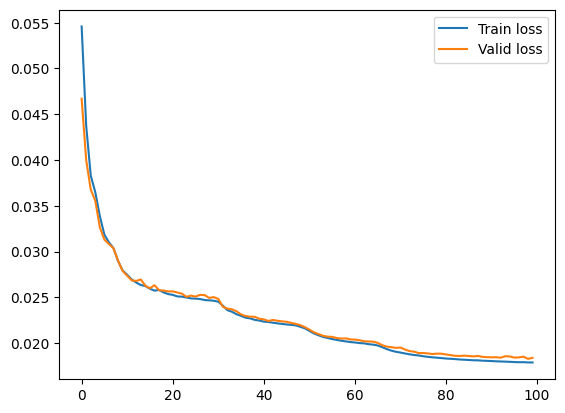

100%|██████████| 100/100 [32:29<00:00, 19.50s/it]


In [30]:
autoencoder = AutoEncoder(input_dim=28*28).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)
autoencoder.fit(mnist_train_loader, mnist_valid_loader, optimizer, 100, device)
torch.save(autoencoder.state_dict(), "best_epochs/AE/mnist_epoch_100")

### CIFAR10

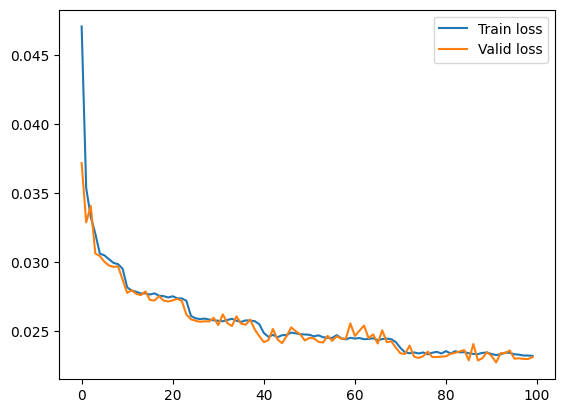

100%|██████████| 100/100 [29:47<00:00, 17.87s/it]


In [31]:
autoencoder = AutoEncoder(input_dim=3*32*32).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)
autoencoder.fit(cifar_train_loader, cifar_valid_loader, optimizer, 100, device)
torch.save(autoencoder.state_dict(), "best_epochs/AE/cifar_epoch_100")

## KMeans

### MNIST

In [45]:
autoencoder = AutoEncoder(input_dim=28*28).to(device)
autoencoder.load_state_dict(torch.load("best_epochs/AE/mnist_epoch_100"))

train_ae = []
for x, y in mnist_train_loader:
    x = x.float()
    x = x.to(device).reshape((x.shape[0], -1))
    train_ae += autoencoder.encode(x).detach().cpu().tolist()
for x, y in mnist_valid_loader:
    x = x.float()
    x = x.to(device).reshape((x.shape[0], -1))
    train_ae += autoencoder.encode(x).detach().cpu().tolist()

train_ae = np.asarray(train_ae)

kmeans = KMeans(n_clusters=10, random_state=42).fit(np.hstack((train_ae, topf_mnist[:60000])))

cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float).cuda()

y_true, hidden_vectors = [], []
for a, b in tqdm(mnist_test_loader):
    a = a.to(device).reshape((a.shape[0], -1))
    hidden_vectors += autoencoder.encode(a).flatten(start_dim=1).tolist()
    y_true += b.tolist()
hidden_vectors = np.asarray(hidden_vectors)
y_true = np.asarray(y_true)

labels = []
for elem in np.hstack((hidden_vectors, topf_mnist[60000:])):
    labels.append(((cluster_centers.cpu().detach().numpy() - elem) ** 2).sum(axis=1).argmin())
labels = np.asarray(labels)
evaluate(y_true, labels, 10)

100%|██████████| 157/157 [00:02<00:00, 60.11it/s]


(0.7909,
 np.float64(0.7330263080685441),
 0.6608666866560021,
 np.float64(0.6954424474911535),
 np.float64(0.7009590372564487))

### CIFAR10

In [56]:
autoencoder = AutoEncoder(input_dim=3*32*32).to(device)
autoencoder.load_state_dict(torch.load("best_epochs/AE/cifar_epoch_100"))

train_ae = []
for x, y in cifar_train_loader:
    x = x.float()
    x = x.to(device).reshape((x.shape[0], -1))
    train_ae += autoencoder.encode(x).detach().cpu().tolist()
for x, y in cifar_valid_loader:
    x = x.float()
    x = x.to(device).reshape((x.shape[0], -1))
    train_ae += autoencoder.encode(x).detach().cpu().tolist()

train_ae = np.asarray(train_ae)

kmeans = KMeans(n_clusters=10, random_state=42).fit(np.hstack((train_ae, topf_cifar[:50000])))

cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float).cuda()

y_true, hidden_vectors = [], []
for a, b in tqdm(cifar_test_loader):
    a = a.to(device).reshape((a.shape[0], -1))
    hidden_vectors += autoencoder.encode(a).flatten(start_dim=1).tolist()
    y_true += b.tolist()
hidden_vectors = np.asarray(hidden_vectors)
y_true = np.asarray(y_true)

labels = []
for elem in np.hstack((hidden_vectors, topf_cifar[50000:])):
    labels.append(((cluster_centers.cpu().detach().numpy() - elem) ** 2).sum(axis=1).argmin())
labels = np.asarray(labels)
evaluate(y_true, labels, 10)

100%|██████████| 157/157 [00:05<00:00, 27.28it/s]


(0.2483,
 np.float64(0.11916494133783914),
 0.06357728108350857,
 np.float64(0.16133414978723382),
 np.float64(0.1654250238982944))

## Deep Embedding Clustering

In [34]:
class DEC(nn.Module):
    def __init__(self, num_clusters=10, autoencoder=None, cluster_centers=None, alpha=1.0):
        super().__init__()
        self.num_clusters = num_clusters
        self.autoencoder = autoencoder
        self.alpha = alpha
        self.cluster_centers = None
        self.criterion = nn.KLDivLoss(reduction='sum')

    def p_distribution(self, q):
        p_numerator = q ** 2 / torch.sum(q, 0)
        p = (p_numerator.t() / torch.sum(p_numerator, 1)).t()
        return p.detach()

    def forward(self, x, topf=None):
        z = self.autoencoder.encode(x)
        if topf is not None:
            z = torch.hstack((z, torch.Tensor(topf).to(device)))
        dist = torch.pow(z.unsqueeze(1) - self.cluster_centers, 2).sum(dim=2)
        q_numerator = 1.0 / (1.0 + dist / self.alpha)
        q_numerator = torch.pow(q_numerator, (self.alpha + 1) / 2)
        q = (q_numerator.t() / torch.sum(q_numerator, 1)).t()
        return q

    @torch.inference_mode()
    def eval_kmeans(self, dataloader, device, topf=None):
        y_true, hidden_vectors = [], []
        for a, b in tqdm(dataloader):
            a = a.to(device).reshape((a.shape[0], -1))
            hidden_vectors += self.autoencoder.encode(a).flatten(start_dim=1).tolist()
            y_true += b.tolist()
        hidden_vectors = np.asarray(hidden_vectors)
        if topf is not None:
            hidden_vectors = np.hstack((hidden_vectors, topf))
        y_true = np.asarray(y_true)

        labels = []
        for elem in hidden_vectors:
            labels.append(((self.cluster_centers.cpu().detach().numpy() - elem) ** 2).sum(axis=1).argmin())
        labels = np.asarray(labels)
        output = evaluate(y_true, labels, 10)
        print(output)
        return output

    def fit(self, origin_dataset, train_indices, train_loader, valid_loader, num_epochs, device, topf_train=None, topf_valid=None, path="/content/"):
        pretrain_kmeans = []

        for x, y in train_loader:
            x = x.float()
            x = x.to(device).reshape((x.shape[0], -1))
            pretrain_kmeans += self.autoencoder.encode(x).detach().cpu().tolist()

        pretrain_kmeans = np.asarray(pretrain_kmeans)
        if topf_train is not None:
            pretrain_kmeans = np.hstack((pretrain_kmeans, topf_train))

        kmeans = KMeans(n_clusters=10).fit(pretrain_kmeans)

        cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float).cuda()
        self.cluster_centers = torch.nn.Parameter(cluster_centers)

        if topf_valid is not None:
            acc, nmi, ari, fmi, bc = self.eval_kmeans(valid_loader, device, topf_valid)
        else:
            acc, nmi, ari, fmi, bc = self.eval_kmeans(valid_loader, device)
        accs, nmis, aris, fmis, bcs = [], [], [], [], []
        accs.append(acc)
        nmis.append(nmi)
        aris.append(ari)
        fmis.append(fmi)
        bcs.append(bc)

        loss_function = nn.KLDivLoss(reduction='sum')
        optimizer = torch.optim.SGD(params=self.parameters(), lr=0.1, momentum=0.9)
        tmp_loader = DataLoader(origin_dataset.data[train_indices], batch_size=len(train_indices), pin_memory=True, shuffle=False)
        train_loss_history = []
        best_acc = acc
        for epoch in range(num_epochs):
            for x in tmp_loader:
                x = x.float() / 255.
                x = x.to(device).reshape((x.shape[0], -1))
                output = self(x, topf_train)
                target = self.p_distribution(output).detach()

                loss = loss_function(output.log(), target) / output.shape[0]
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss_history.append(loss.item())

            if topf_valid is not None:
                acc, nmi, ari, fmi, bc = self.eval_kmeans(valid_loader, device, topf_valid)
            else:
                acc, nmi, ari, fmi, bc = self.eval_kmeans(valid_loader, device)
            accs.append(acc)
            nmis.append(nmi)
            aris.append(ari)
            fmis.append(fmi)
            bcs.append(bc)
            if acc > best_acc:
                best_acc = acc
                torch.save(self.state_dict(), "{path}/epoch_{epoch}".format(path=path, epoch=epoch))

            clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(15, 8))
            axes[0].plot(train_loss_history, label='Train loss')
            # axes[0].plot(valid_loss_history, label='Valid loss')
            axes[1].plot(accs, label='acc')
            axes[1].plot(nmis, label='nmi')
            axes[1].plot(aris, label='ari')
            axes[1].plot(fmis, label='fmi')
            axes[1].plot(bcs, label='BCubed')
            axes[1].legend()
            axes[0].legend()
            plt.show()

### MNIST

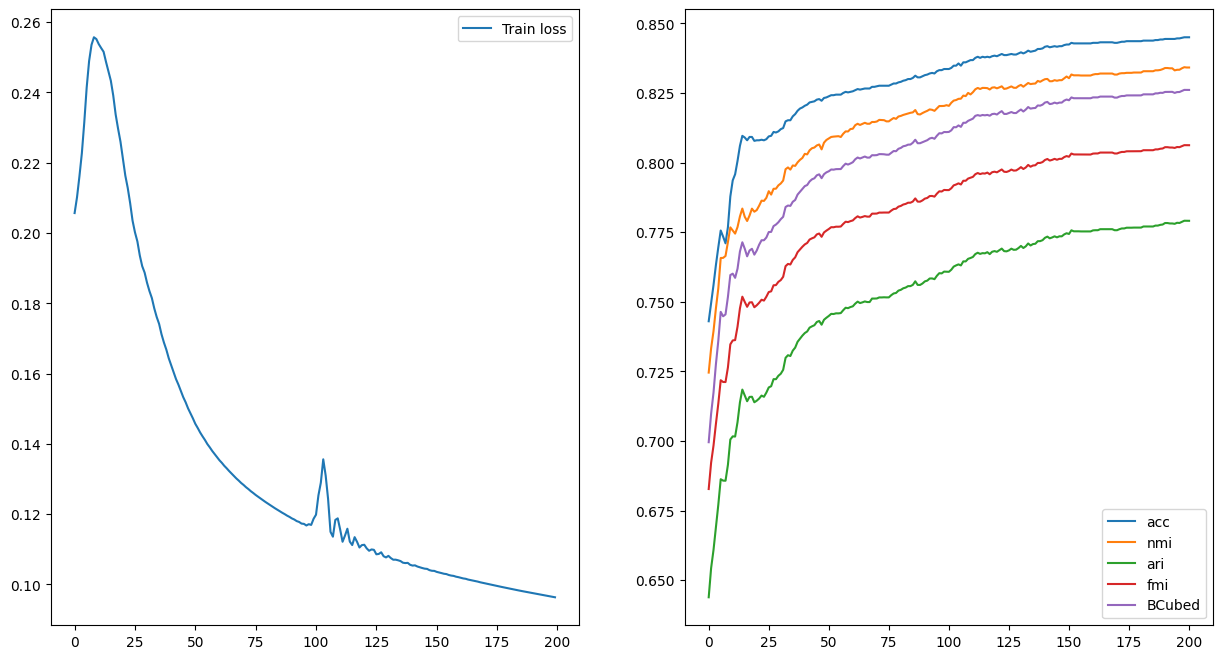

In [35]:
autoencoder = AutoEncoder(input_dim=28*28).to(device)
autoencoder.load_state_dict(torch.load("best_epochs/AE/mnist_epoch_100"))

dec = DEC(autoencoder=autoencoder)
dec.fit(num_epochs=200, device=device, train_loader=mnist_train_loader, valid_loader=mnist_valid_loader, origin_dataset=mnist_train, train_indices=mnist_train_set.indices, 
        topf_train=topf_mnist[:55000], topf_valid=topf_mnist[55000:60000], path="best_epochs/DEC/MNIST")

In [36]:
dec.eval_kmeans(mnist_test_loader, device, topf_mnist[60000:])

100%|██████████| 157/157 [00:01<00:00, 82.49it/s]


(0.8351, np.float64(0.8347193019383307), 0.7707397003184716, np.float64(0.7991747651511846), np.float64(0.8228793029159839))


(0.8351,
 np.float64(0.8347193019383307),
 0.7707397003184716,
 np.float64(0.7991747651511846),
 np.float64(0.8228793029159839))

### CIFAR10

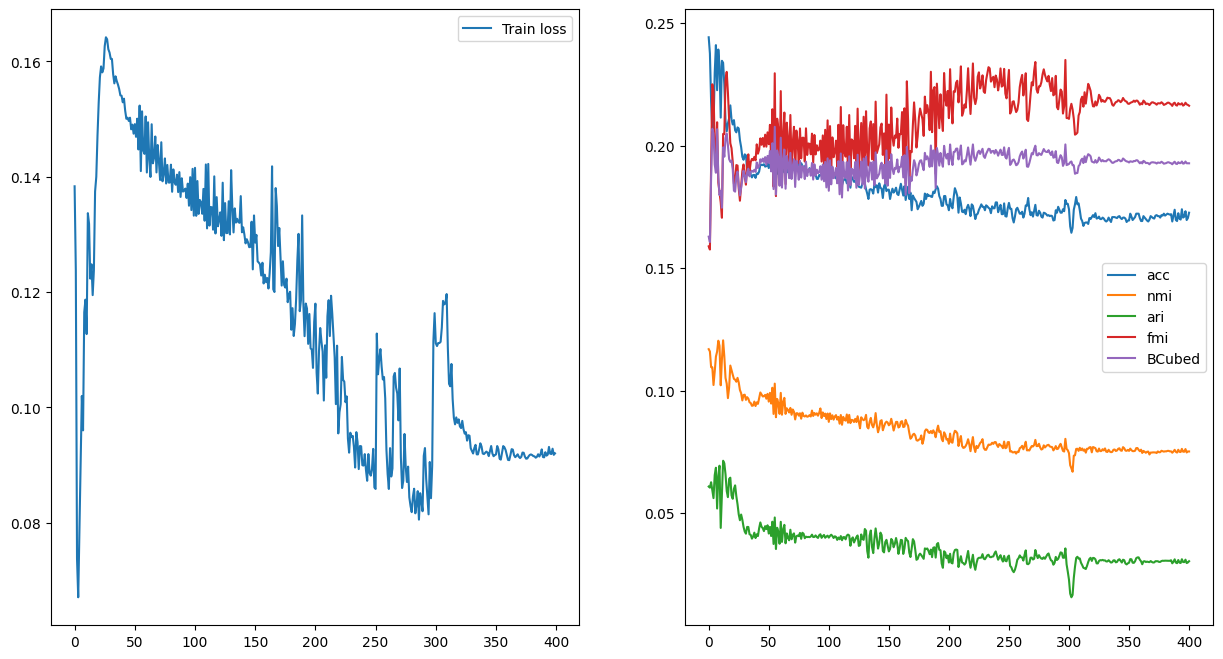

In [60]:
autoencoder = AutoEncoder(input_dim=3*32*32).to(device)
autoencoder.load_state_dict(torch.load("best_epochs/AE/cifar_epoch_100"))

dec = DEC(autoencoder=autoencoder)
dec.fit(num_epochs=400, device=device, train_loader=cifar_train_loader, valid_loader=cifar_valid_loader, origin_dataset=cifar_train, train_indices=cifar_train_set.indices, 
        topf_train=topf_cifar[:45000], topf_valid=topf_cifar[45000:50000], path="best_epochs/DEC/CIFAR10")

In [61]:
dec.eval_kmeans(cifar_test_loader, device, topf_cifar[50000:])

100%|██████████| 157/157 [00:05<00:00, 30.78it/s]


(0.1749, np.float64(0.07552058995923767), 0.03086838260608505, np.float64(0.2176499958244984), np.float64(0.19384038136790518))


(0.1749,
 np.float64(0.07552058995923767),
 0.03086838260608505,
 np.float64(0.2176499958244984),
 np.float64(0.19384038136790518))

## Contrastive Clustering

### MNIST

In [62]:
class CCLoss(nn.Module):
    def __init__(self, temperature, batch_size, num_clusters, device, alpha=0.5):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.batch_size = batch_size
        self.num_clusters = num_clusters
        self.device = device

        self.instance_loss_mask = self.create_mask(batch_size)
        self.cluster_loss_mask = self.create_mask(num_clusters)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")

    def create_mask(self, n):
        mask = torch.ones((n, n))
        mask = mask.fill_diagonal_(0)
        mask = torch.cat((mask, mask))
        return torch.cat((mask, mask), dim=1).bool().to(self.device)

    def instance_loss(self, similarities, mask):
        N = mask.shape[0]
        positive_1 = torch.diag(similarities, int(N // 2))
        positive_2 = torch.diag(similarities, -int(N // 2))
        positives = torch.cat((positive_1, positive_2), dim=0).to(self.device)
        positives = positives.reshape(N, 1)
        negatives = similarities[mask].reshape(N, -1)
        # loss = (torch.exp(positives) / similarities.sum()).sum()
        labels = torch.zeros(N).to(self.device).long()
        logits = torch.cat((positives, negatives), dim=1).to(self.device)
        loss = self.criterion(logits, labels) / N

        return loss

    def calc_log_loss(self, c):
        p = c.sum(0).view(-1).to(self.device)
        p /= p.sum()
        return (p * torch.log(p)).sum()

    def cluster_loss(self, c1, c2):
        similarity_f = nn.CosineSimilarity(dim=2)
        c = torch.cat((c1.t(), c2.t()), dim=0)
        similarities = similarity_f(c.unsqueeze(1), c.unsqueeze(0)) / self.temperature
        loss = self.instance_loss(similarities, self.cluster_loss_mask)
        h_loss = self.calc_log_loss(c1) + self.calc_log_loss(c2)
        return loss + h_loss

    def forward(self, x1, c1, x2, c2):
        cur_batch = torch.cat((x1, x2))
        similarities = (cur_batch @ cur_batch.T / self.temperature).to(self.device)

        return self.alpha * self.instance_loss(similarities, self.instance_loss_mask) + (1 - self.alpha) * self.cluster_loss(c1, c2)

In [63]:
class ContrastiveClustering(nn.Module):
    def __init__(self, n_clusters, hidden_dim, autoencoder=None, ae_input_dim=28*28, topf_dim=0):
        super().__init__()
        self.autoencoder = autoencoder
        self.topf_dim = topf_dim
        
        if self.autoencoder is not None:
            with torch.no_grad():
                sample = torch.randn(1, ae_input_dim).to(device)
                latent_dim = autoencoder.encode(sample).shape[-1]
            self.latent_dim = latent_dim
        else:
            self.latent_dim = 0
            
        projector_input_dim = self.latent_dim + topf_dim

        self.instances_projector = nn.Sequential(
            nn.Linear(projector_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, hidden_dim),
        )
        self.cluster_projector = nn.Sequential(
            nn.Linear(projector_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, n_clusters),
            nn.Softmax(dim=1),
        )

        self.n_clusters = n_clusters
        self.hidden_dim = hidden_dim
        self.device = None

    def forward(self, x, topf=None):
        x = x.float()
        x = x.to(device).reshape((x.shape[0], -1))
        z = self.autoencoder.encode(x)
        if topf is not None:
            if isinstance(topf, np.ndarray):
                topf = torch.FloatTensor(topf).to(self.device)
            z = torch.cat((z, topf), dim=1)
        
        hidden_features = self.instances_projector(z)
        hidden_features = torch.nn.functional.normalize(hidden_features, dim=1)
        cluster_assignment = self.cluster_projector(z)
        return hidden_features, cluster_assignment

    def get_cluster(self, x, topf=None):
        with torch.no_grad():
            x = x.float()
            x = x.to(device).reshape((x.shape[0], -1))
            z = self.autoencoder.encode(x)
            if topf is not None:
                if isinstance(topf, np.ndarray):
                    topf = torch.FloatTensor(topf).to(self.device)
                z = torch.cat((z, topf), dim=1)
            cluster_assignment = self.cluster_projector(z)
            return cluster_assignment.argmax(dim=1)

    def training_epoch(self, data_loader, optimizer, device, topf_train=None):
        self.train()
        total_loss = 0
        batch_count = 0
        
        for batch_id, ((x1, x2), _) in enumerate(tqdm(data_loader)):
            x1 = x1.to(device)
            x2 = x2.to(device)
            
            batch_size = x1.shape[0]
            start_id = batch_id * data_loader.batch_size
            end_id = start_id + batch_size
            
            topf1 = topf_train[start_id:end_id] if topf_train is not None else None
            topf2 = topf_train[start_id:end_id] if topf_train is not None else None
            
            h1, c1 = self(x1, topf1)
            h2, c2 = self(x2, topf2)

            optimizer.zero_grad()
            loss = self.loss_fn(h1, c1, h2, c2)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_count += 1
            
            if batch_count > 100:
                break

        return total_loss / batch_count

    @torch.inference_mode()
    def evaluate(self, data_loader, device, topf_valid=None):
        self.eval()
        total_loss = 0
        batch_count = 0

        for batch_id, ((x1, x2), _) in enumerate(tqdm(data_loader)):
            x1 = x1.to(device)
            x2 = x2.to(device)
            
            batch_size = x1.shape[0]
            start_id = batch_id * data_loader.batch_size
            end_id = start_id + batch_size
            
            topf1 = topf_valid[start_id:end_id] if topf_valid is not None else None
            topf2 = topf_valid[start_id:end_id] if topf_valid is not None else None
            
            h1, c1 = self(x1, topf1)
            h2, c2 = self(x2, topf2)

            loss = self.loss_fn(h1, c1, h2, c2)
            total_loss += loss.item()
            batch_count += 1
            
            if batch_count > 20:
                break

        return total_loss / batch_count if batch_count > 0 else 0

    def get_metrics(self, data_loader, device, topf=None):
        self.eval()
        y_true, predictions = [], []
        
        for batch_id, ((x1, _), labels) in enumerate(tqdm(data_loader)):
            x1 = x1.to(device)
            
            batch_size = x1.shape[0]
            start_id = batch_id * data_loader.batch_size
            end_id = start_id + batch_size
            
            current_topf = topf[start_id:end_id] if topf is not None else None
            
            batch_pred = self.get_cluster(x1, current_topf)
            predictions.extend(batch_pred.cpu().tolist())
            y_true.extend(labels.tolist())
            
        predictions = np.asarray(predictions)
        y_true = np.asarray(y_true)
        output = evaluate(y_true, predictions, self.n_clusters)
        print(output)
        return output

    def fit(self, train_loader, val_loader, optimizer, n_epochs, device, 
            topf_train=None, topf_valid=None, early_stopping_patience=5):
        self.loss_fn = CCLoss(temperature=1, batch_size=train_loader.batch_size, 
                             num_clusters=self.n_clusters, device=device, alpha=0.5)
        self.device = device
        self.metrics = []

        train_loss_history, valid_loss_history = [], []
        accs, nmis, aris, fmis, bcs = [], [], [], [], []
        
        for epoch in range(n_epochs):
            print(f'Epoch {epoch+1}/{n_epochs}')
            
            train_loss = self.training_epoch(train_loader, optimizer, device, topf_train)
            valid_loss = self.evaluate(val_loader, device, topf_valid)

            train_loss_history.append(train_loss)
            valid_loss_history.append(valid_loss)
            
            acc, nmi, ari, fmi, bc = self.get_metrics(val_loader, device, topf_valid)
            self.metrics.append([acc, nmi, ari, fmi, bc])

            accs.append(acc)
            nmis.append(nmi)
            aris.append(ari)
            fmis.append(fmi)
            bcs.append(bc)

            clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(15, 8))
            axes[0].plot(train_loss_history, label='Train loss')
            axes[0].plot(valid_loss_history, label='Valid loss')
            axes[0].legend()
            
            axes[1].plot(accs, label='acc')
            axes[1].plot(nmis, label='nmi')
            axes[1].plot(aris, label='ari')
            axes[1].plot(fmis, label='fmi')
            axes[1].plot(bcs, label='BCubed')
            axes[1].legend()
            
            plt.show()
            print(f'Metrics: ACC={acc:.4f}, NMI={nmi:.4f}, ARI={ari:.4f}, FMI={fmi:.4f}, BCubed={bc:.4f}')

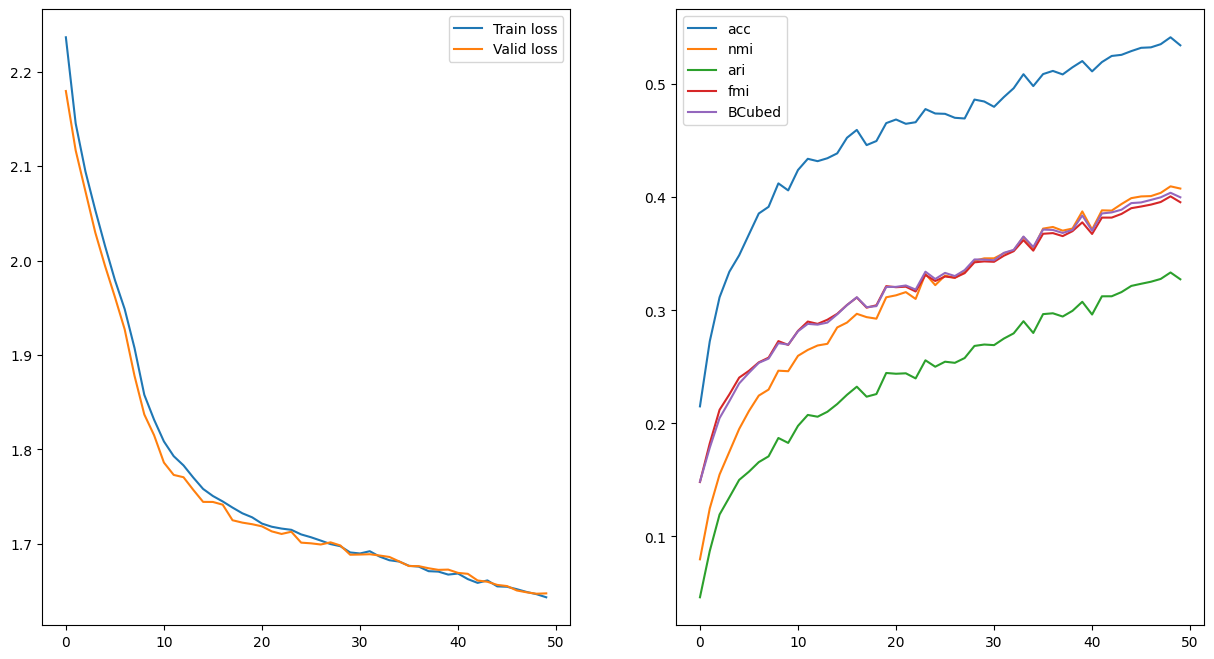

Metrics: ACC=0.5344, NMI=0.4077, ARI=0.3274, FMI=0.3956, BCubed=0.4000


In [ ]:
autoencoder = AutoEncoder(input_dim=28*28).to(device)
autoencoder.load_state_dict(torch.load("best_epochs/AE/mnist_epoch_100"))

cc_model = ContrastiveClustering(n_clusters=10, hidden_dim=100, autoencoder=autoencoder, ae_input_dim=28*28, topf_dim=topf_mnist.shape[1]).to(device)
optimizer = torch.optim.Adam(cc_model.parameters(), lr=1e-4)
n_epochs = 100

# topf_mnist нужно обрезать, так как в loaders для cc drop_last=True
# 256*(60000//256)=59904 и 256*(10000//256)=9984
cc_model.fit(mnist_cc_train_loader, mnist_cc_valid_loader, optimizer, n_epochs, device, 
             topf_train=topf_mnist[:59904], topf_valid=topf_mnist[60000:69984])

### CIFAR10

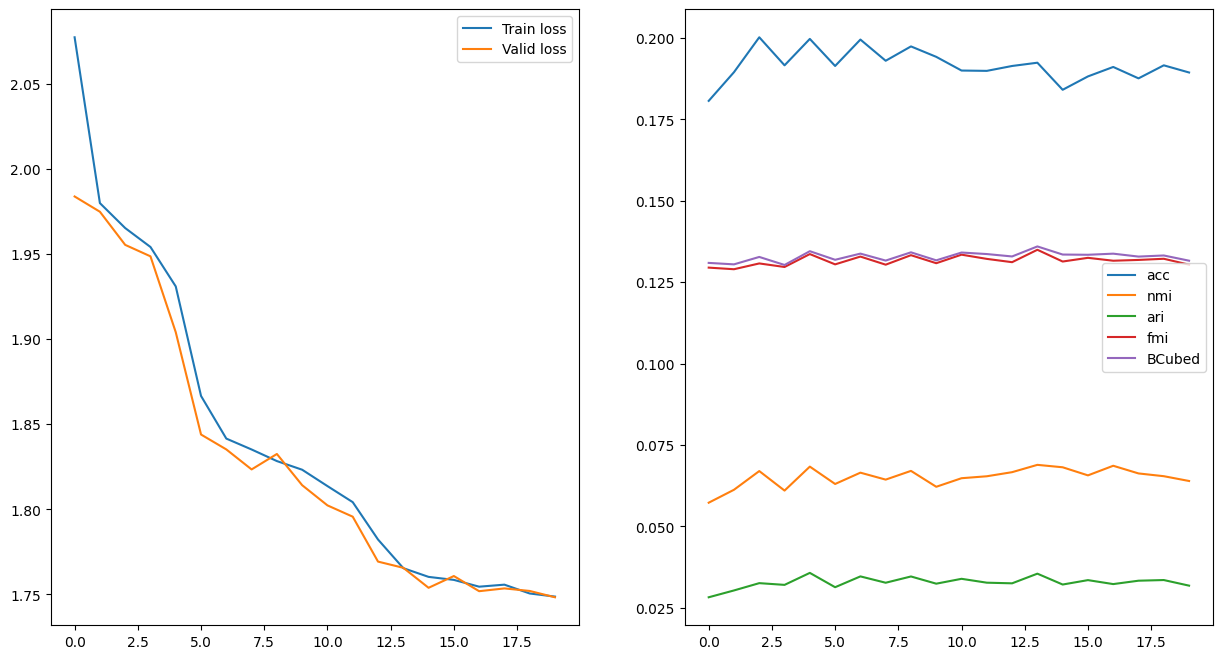

Metrics: ACC=0.1894, NMI=0.0639, ARI=0.0318, FMI=0.1304, BCubed=0.1316


In [ ]:
autoencoder = AutoEncoder(input_dim=3*32*32).to(device)
autoencoder.load_state_dict(torch.load("best_epochs/AE/cifar_epoch_100"))

cc_model = ContrastiveClustering(n_clusters=10, hidden_dim=100, autoencoder=autoencoder, ae_input_dim=3*32*32, topf_dim=topf_cifar.shape[1]).to(device)
optimizer = torch.optim.Adam(cc_model.parameters(), lr=3e-4)
n_epochs = 50

# 256*(50000//256)=49902 и 256*(10000//256)=9984
cc_model.fit(cifar_cc_train_loader, cifar_cc_valid_loader, optimizer, n_epochs, device, 
             topf_train=topf_cifar[:49920], topf_valid=topf_cifar[50000:59984])

## without topf

### KMeans

In [58]:
autoencoder = AutoEncoder(input_dim=28*28).to(device)
autoencoder.load_state_dict(torch.load("best_epochs/AE/mnist_epoch_100"))

train_ae = []
for x, y in mnist_train_loader:
    x = x.float()
    x = x.to(device).reshape((x.shape[0], -1))
    train_ae += autoencoder.encode(x).detach().cpu().tolist()
for x, y in mnist_valid_loader:
    x = x.float()
    x = x.to(device).reshape((x.shape[0], -1))
    train_ae += autoencoder.encode(x).detach().cpu().tolist()

train_ae = np.asarray(train_ae)

kmeans = KMeans(n_clusters=10, random_state=42).fit(train_ae)

cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float).cuda()

y_true, hidden_vectors = [], []
for a, b in tqdm(mnist_test_loader):
    a = a.to(device).reshape((a.shape[0], -1))
    hidden_vectors += autoencoder.encode(a).flatten(start_dim=1).tolist()
    y_true += b.tolist()
hidden_vectors = np.asarray(hidden_vectors)
y_true = np.asarray(y_true)

labels = []
for elem in hidden_vectors:
    labels.append(((cluster_centers.cpu().detach().numpy() - elem) ** 2).sum(axis=1).argmin())
labels = np.asarray(labels)
evaluate(y_true, labels, 10)

100%|██████████| 157/157 [00:04<00:00, 33.87it/s]


(0.74,
 np.float64(0.7190634045318324),
 0.633085817846861,
 np.float64(0.6718121366675649),
 np.float64(0.689768386909057))

In [57]:
autoencoder = AutoEncoder(input_dim=3*32*32).to(device)
autoencoder.load_state_dict(torch.load("best_epochs/AE/cifar_epoch_100"))

train_ae = []
for x, y in cifar_train_loader:
    x = x.float()
    x = x.to(device).reshape((x.shape[0], -1))
    train_ae += autoencoder.encode(x).detach().cpu().tolist()
for x, y in cifar_valid_loader:
    x = x.float()
    x = x.to(device).reshape((x.shape[0], -1))
    train_ae += autoencoder.encode(x).detach().cpu().tolist()

train_ae = np.asarray(train_ae)

kmeans = KMeans(n_clusters=10, random_state=42).fit(train_ae, topf_cifar[:50000])

cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float).cuda()

y_true, hidden_vectors = [], []
for a, b in tqdm(cifar_test_loader):
    a = a.to(device).reshape((a.shape[0], -1))
    hidden_vectors += autoencoder.encode(a).flatten(start_dim=1).tolist()
    y_true += b.tolist()
hidden_vectors = np.asarray(hidden_vectors)
y_true = np.asarray(y_true)

labels = []
for elem in hidden_vectors:
    labels.append(((cluster_centers.cpu().detach().numpy() - elem) ** 2).sum(axis=1).argmin())
labels = np.asarray(labels)
evaluate(y_true, labels, 10)

100%|██████████| 157/157 [00:04<00:00, 32.78it/s]


(0.2494,
 np.float64(0.11965124338966403),
 0.06382695798739475,
 np.float64(0.16149269102856872),
 np.float64(0.16552879747269678))

### DEC

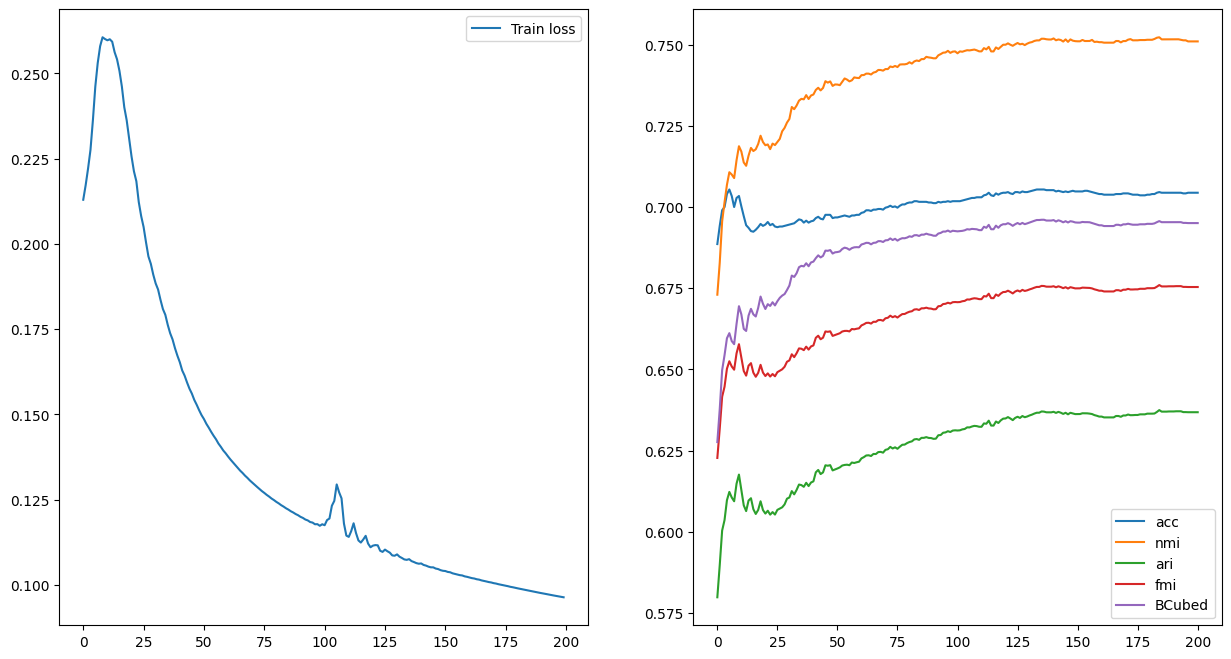

In [47]:
autoencoder = AutoEncoder(input_dim=28*28).to(device)
autoencoder.load_state_dict(torch.load("best_epochs/AE/mnist_epoch_100"))

dec = DEC(autoencoder=autoencoder)
dec.fit(num_epochs=200, device=device, train_loader=mnist_train_loader, valid_loader=mnist_valid_loader, origin_dataset=mnist_train, train_indices=mnist_train_set.indices, path="best_epochs/DEC/MNIST")

In [48]:
dec.eval_kmeans(mnist_test_loader, device)

100%|██████████| 157/157 [00:02<00:00, 72.68it/s]


(0.6918, np.float64(0.7483360840605), 0.6172672142858396, np.float64(0.6580408831800086), np.float64(0.6865013503528645))


(0.6918,
 np.float64(0.7483360840605),
 0.6172672142858396,
 np.float64(0.6580408831800086),
 np.float64(0.6865013503528645))

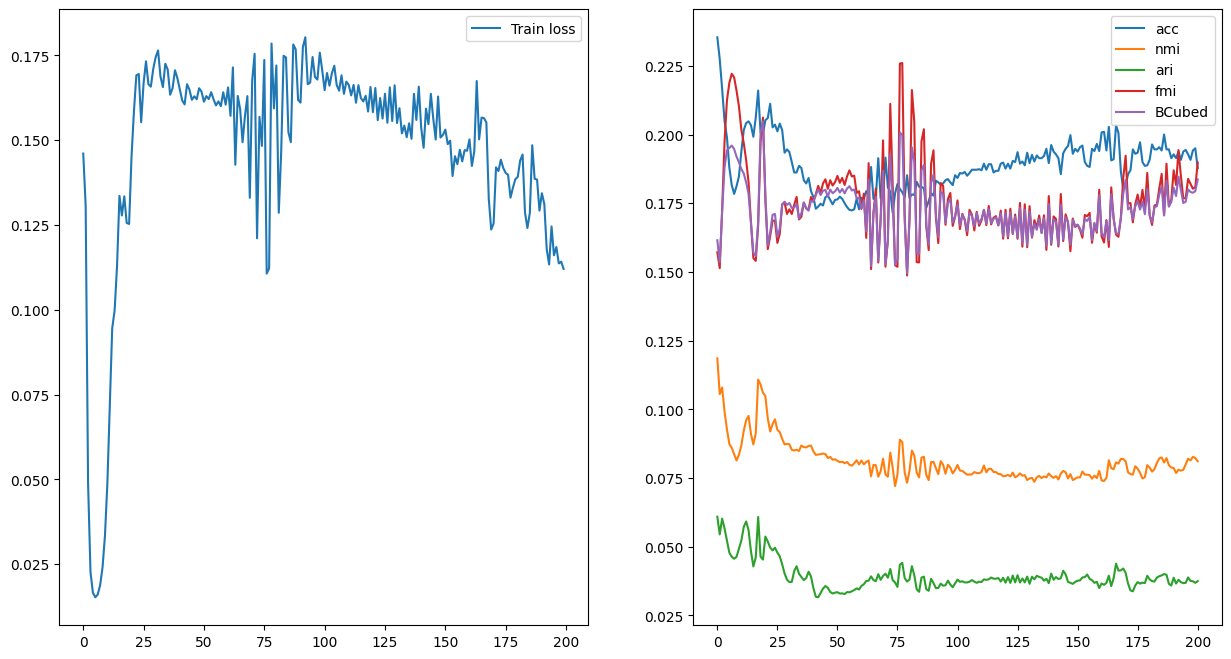

In [49]:
autoencoder = AutoEncoder(input_dim=3*32*32).to(device)
autoencoder.load_state_dict(torch.load("best_epochs/AE/cifar_epoch_100"))

dec = DEC(autoencoder=autoencoder)
dec.fit(num_epochs=200, device=device, train_loader=cifar_train_loader, valid_loader=cifar_valid_loader, origin_dataset=cifar_train, train_indices=cifar_train_set.indices, path="best_epochs/DEC/CIFAR10")

In [50]:
dec.eval_kmeans(cifar_test_loader, device)

100%|██████████| 157/157 [00:02<00:00, 58.81it/s]


(0.1911, np.float64(0.0828644020169731), 0.03778716022108478, np.float64(0.1913869228139952), np.float64(0.18499172385599924))


(0.1911,
 np.float64(0.0828644020169731),
 0.03778716022108478,
 np.float64(0.1913869228139952),
 np.float64(0.18499172385599924))

### CC

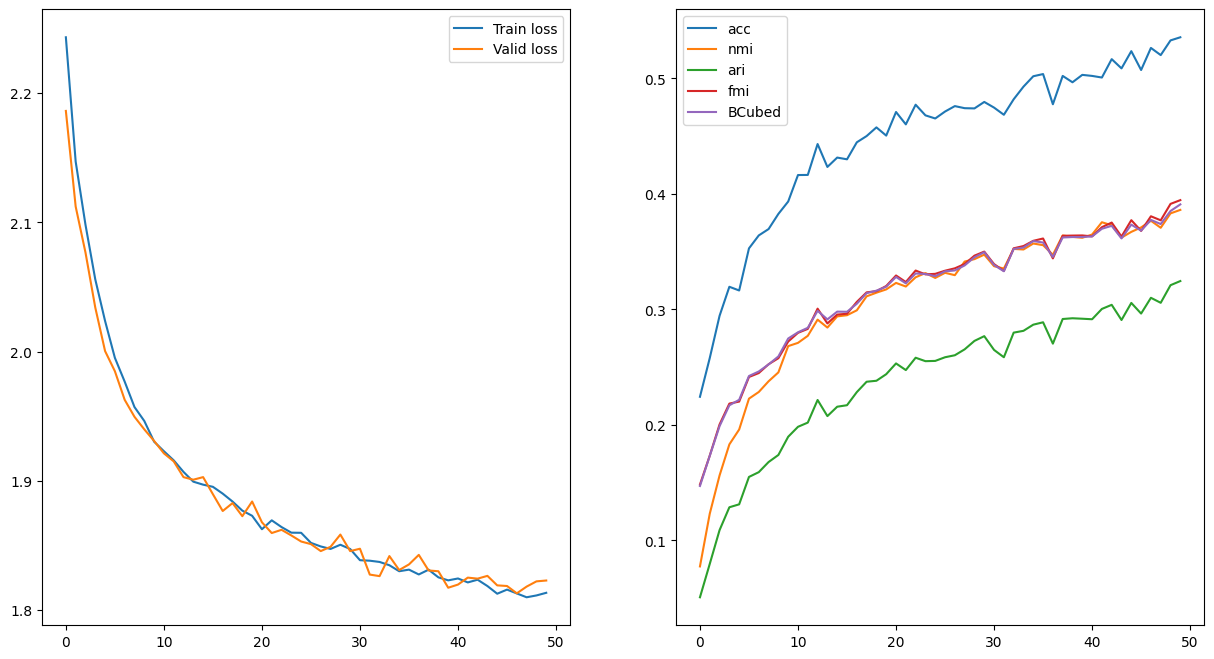

Metrics: ACC=0.5356, NMI=0.3861, ARI=0.3245, FMI=0.3945, BCubed=0.3909


In [51]:
autoencoder = AutoEncoder(input_dim=28*28).to(device)
autoencoder.load_state_dict(torch.load("best_epochs/AE/mnist_epoch_100"))

cc_model = ContrastiveClustering(n_clusters=10, hidden_dim=100, autoencoder=autoencoder, ae_input_dim=28*28).to(device)
optimizer = torch.optim.Adam(cc_model.parameters(), lr=1e-4)
n_epochs = 50

cc_model.fit(mnist_cc_train_loader, mnist_cc_valid_loader, optimizer, n_epochs, device)

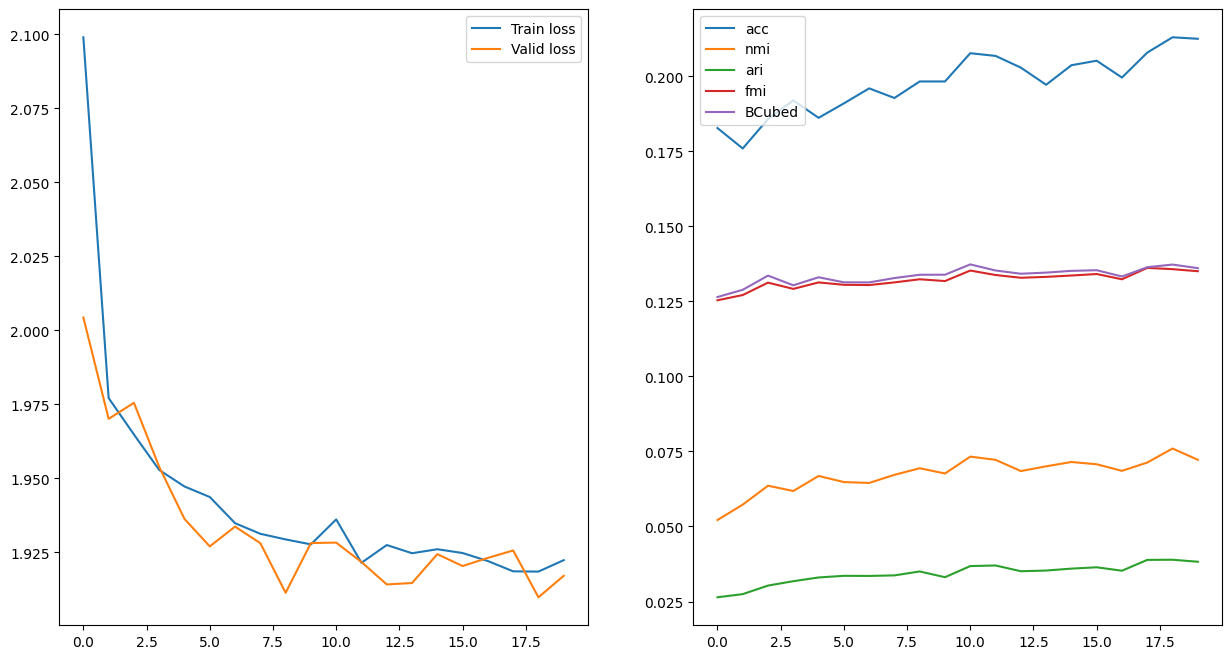

Metrics: ACC=0.2125, NMI=0.0722, ARI=0.0383, FMI=0.1351, BCubed=0.1361


In [52]:
autoencoder = AutoEncoder(input_dim=3*32*32).to(device)
autoencoder.load_state_dict(torch.load("best_epochs/AE/cifar_epoch_100"))

cc_model = ContrastiveClustering(n_clusters=10, hidden_dim=100, autoencoder=autoencoder, ae_input_dim=3*32*32).to(device)
optimizer = torch.optim.Adam(cc_model.parameters(), lr=3e-4)
n_epochs = 20

cc_model.fit(cifar_cc_train_loader, cifar_cc_valid_loader, optimizer, n_epochs, device)